# Building the dataset

## Croping LoTSS-DR1 sources from data mosaics with montage

LoTSS-DR1 products available: Mosaics, PyBDSF and Optical Catalogues.

* We use the high resolution mosaics (HETDEX, 58 mosaics in total, 6“) to extract small regions around the radio source coordinates.
* We use a catalogue with the correspondence between the pybdsf sources and the final optical associations (compiled by Lara).

Useful links to work with MONTAGE - NASA:
* https://github.com/Caltech-IPAC/MontageNotebooks/blob/master/mSubimage.ipynb
* http://montage.ipac.caltech.edu/MontageNotebooks/Mosaic.html
* http://montage.ipac.caltech.edu/docs/mSubimage.html

In [2]:
# Required to work with the tables and crop the mosaics
from astropy.table import Table, unique, vstack
from MontagePy.main import mSubimage
from astropy import units as u
import time

In [ ]:
# Required for visualisation
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits, ascii

## Catalogues

In [4]:
# Loading the PyBDSF optical associations catalogue with different classes
# This catalogue is the output of PyBDSF_DR1_associations_classes.ipynb (Lara)
with fits.open('pybdsf_associations_classes.fits') as cat:
    pybdsf_classes = Table(cat[1].data)#.to_pandas()

In [5]:
# Total number of rows
len(pybdsf_classes)

326591

In [6]:
pybdsf_classes

Source_Name,flag,RA,DEC,Mosaic_ID,AllWISE_lr,objID_lr,lr,lr_dist,Source_Name_final,RA_final,DEC_final,ID_flag,AllWISE_final,objID_final,accept_lr,multi
str22,int64,float64,float64,str8,str19,str18,float64,float64,str22,float64,float64,float64,str19,str18,int64,int64
ILTJ104325.11+520938.1,8,160.8546373845866,52.16060580392516,P4Hetdex,J104325.10+520935.9,999999,2.8406122557095017,2.2132861927473795,ILTJ104324.59+520940.6,160.85247160073476,52.16130116588639,32.0,J104324.67+520948.0,999999,0,1
ILTJ104325.73+520904.7,8,160.85722371280463,52.15131729982779,P4Hetdex,J104325.50+520904.2,999999,71.88923641771363,2.153849151744342,ILTJ104324.59+520940.6,160.85247160073476,52.16130116588639,32.0,J104324.67+520948.0,999999,0,1
ILTJ104327.08+520836.0,8,160.8628192571188,52.143358973538874,P4Hetdex,,999999,5.990127929483526e-58,10.672803793313125,ILTJ104324.59+520940.6,160.85247160073476,52.16130116588639,32.0,J104324.67+520948.0,999999,0,1
ILTJ104444.86+512501.6,8,161.18689595351347,51.41711516688594,P4Hetdex,,999999,6.07768093750162e-39,12.877874631917622,ILTJ104445.73+512432.7,161.1905249659982,51.40910497974905,31.0,,999999,0,1
ILTJ104445.97+512424.5,8,161.19155874167404,51.406823164336224,P4Hetdex,,999999,6.151935545602644e-63,10.883161182036465,ILTJ104445.73+512432.7,161.1905249659982,51.40910497974905,31.0,,999999,0,1
ILTJ104449.33+513440.7,8,161.20554546155716,51.57797522336314,P4Hetdex,,999999,0.5937507560024395,7.1882986480326725,ILTJ104450.87+513440.6,161.21195634942947,51.57796285003475,31.0,J104451.21+513442.4,169891612135234672,0,1
ILTJ104452.19+513440.6,8,161.21744006929188,51.577952266186145,P4Hetdex,,999999,5.375476859605163e-09,8.959869977902798,ILTJ104450.87+513440.6,161.21195634942947,51.57796285003475,31.0,J104451.21+513442.4,169891612135234672,0,1
ILTJ104535.93+513051.4,8,161.39968754013174,51.5142957558506,P4Hetdex,,999999,8.031279398374041e-120,14.182650841591212,ILTJ104536.07+513047.9,161.40028614996777,51.513328462855554,31.0,,999999,0,1
ILTJ104536.29+513042.5,8,161.40121666524612,51.51182484421069,P4Hetdex,,999999,nan,nan,ILTJ104536.07+513047.9,161.40028614996777,51.513328462855554,31.0,,999999,0,1


**DESCRIPTION OF THE COLUMNS**
* **Source_Name**: original PyBDSF radio Source_Name
* **flag**: flag system described in https://laraalegre.github.io/lotss-dr1/
* **RA & DEC**: original coordinates of PyBDSF radio Source_Name
* **AllWISE_lr & objID_lr**: WISE and PANSTARRS cross-matched by likelihood ratio (lr)
* **lr & lr_dist**: value of the lr for the cross-matched source (WISE when available; if not PANSTARRS) and correspondent distance to the radio source position
* **Source_Name_final**: PyBDSF radio Source_Name after association (or dissociation) after visual inspection or deblend workflow
* **RA_final & DEC_final**: coordinates of PyBDSF radio Source_Name_final
* **Mosaic_ID**: Mosaic where the source belongs (information taken from the optical catalogue)
* **ID_flag**: flag system described in Williams et al. 2018
* **AllWISE_final & objID_final**: WISE and PANSTARRS cross-matched after visual inspection
* **accept_lr**: Cross-match was made by lr (1) or required visual inspection (0)
* **multi**: Source required grouping different PyBDSF radio sources (1) or not (0)

 # SOME NOTES: 
 * We will use the original PyBDSF RA and DEC to crop the images and create the dataset.
 * single sources will be centred in the image (and appear just once on the dataset)
 * multiple sources:
     * appear 2 or more times on the dataset (it will look repeated);
     * will not be centreded, i.e. each of the components is centred at a time.
 * We will just use flags where the source classification is accurate - 1 (singles) and 4 (deblends),and 8 (multi).
 * The dataset will contain multi sources (flag 8) and not multi(flags 1 and 2), which we call singles, for simplicity. This info comes from multi column.
 * Mosaic ID are not correct on the catalogues and need to be corrected (see below)
 * Size of the output images is 128x128 **check this** - (too big for some)...to small to others. It is a compromise. Can be changed. 

### Cleaning MOSAIC ID names in the catalogue

In [7]:
# Mosaic_ID missing last characters of the name.
unique(pybdsf_classes, keys ='Mosaic_ID')['Mosaic_ID'][0:3]

P10Hetde
P11Hetde
P12Hetde


In [8]:
# Change dtype of Mosaic_ID column
pybdsf_classes['Mosaic_ID'] = pybdsf_classes.Column(pybdsf_classes['Mosaic_ID'], dtype ='<U11')

In [9]:
# Taking the list of the available mosaics
mosaics_count = np.array(ascii.read("mosaics_names.dat")['Mosaic_ID'])

In [10]:
# Changing mosaic names
for i in range(0,len(unique(pybdsf_classes, keys ='Mosaic_ID'))):
    pybdsf_classes['Mosaic_ID'][np.where(pybdsf_classes['Mosaic_ID'] == mosaics_count[i][0:8])] = mosaics_count[i]

In [11]:
# Great
unique(pybdsf_classes, keys ='Mosaic_ID')['Mosaic_ID'][0:3]

P10Hetdex
P11Hetdex12
P12Hetdex11


## Defining the dataset 

* Just use sources with flags 1, 4 and 8 (flag system described in https://laraalegre.github.io/lotss-dr1/)
* Take all the 8s and all the 4s and take random 1s.

In [12]:
# Define the number of random singles
n_samples = len(pybdsf_classes[pybdsf_classes['flag'] == 8]) - \
            len(unique(pybdsf_classes[pybdsf_classes['flag'] == 4], keys = 'Source_Name'))
print('Taking', n_samples, 'singles')
# Taking a set of random singles. Easy to do in pandas
sample_singles = Table.from_pandas(pybdsf_classes[pybdsf_classes['flag'] == 1].to_pandas().\
                        sample(n = n_samples, random_state = 42))

Taking 8127 singles


In [13]:
# Taking all the 8 and 4
sample_multi = pybdsf_classes[(pybdsf_classes['flag'] == 4) | (pybdsf_classes['flag'] == 8)]
# Note some 4s are also 12 - THIS HAPPENS FOR 23 SOURCES
# CONFIRM WITH PHILIP

In [25]:
# Concatenating the multi and single samples
pybdsf_classes_sample = vstack([sample_singles, sample_multi])
# Size of the sample
print(len(pybdsf_classes_sample), len(unique(pybdsf_classes_sample, keys = 'Source_Name')),\
     len(unique(pybdsf_classes_sample[pybdsf_classes_sample['flag'] == 4], keys = 'Source_Name')),\
     len(unique(pybdsf_classes_sample[pybdsf_classes_sample['flag'] == 1], keys = 'Source_Name')),\
     len(unique(pybdsf_classes_sample[pybdsf_classes_sample['flag'] == 8], keys = 'Source_Name')))

18884 18014 880 8127 9007


## Images 

In [14]:
# Setting the path where the mosaics can be found
mosaics_path = '/Volumes/lara_intel/LOFAR/lotss-dr1-dl/data/mosaics'#'data/mosaics'

In [ ]:
# Setting the path where the cropped images will be stored
dataset_path = '/Volumes/lara_intel/LOFAR/lotss-dr1-dl/data/dataset'#'data/dataset'

In [16]:
mosaics_count

array(['P10Hetdex', 'P11Hetdex12', 'P12Hetdex11', 'P14Hetdex04',
       'P15Hetdex13', 'P164+55', 'P169+55', 'P16Hetdex13', 'P173+55',
       'P178+55', 'P182+55', 'P187+55', 'P18Hetdex03', 'P191+55',
       'P196+55', 'P19Hetdex17', 'P1Hetdex15', 'P200+55', 'P205+55',
       'P206+50', 'P206+52', 'P209+55', 'P21', 'P210+47', 'P211+50',
       'P213+47', 'P214+55', 'P217+47', 'P218+55', 'P219+50', 'P219+52',
       'P221+47', 'P223+50', 'P223+52', 'P223+55', 'P225+47', 'P227+50',
       'P227+53', 'P22Hetdex04', 'P23Hetdex20', 'P25Hetdex09',
       'P26Hetdex03', 'P27Hetdex09', 'P29Hetdex19', 'P30Hetdex06',
       'P33Hetdex08', 'P34Hetdex06', 'P35Hetdex10', 'P37Hetdex15',
       'P38Hetdex07', 'P39Hetdex19', 'P3Hetdex16', 'P41Hetdex',
       'P42Hetdex07', 'P4Hetdex16', 'P6', 'P7Hetdex11', 'P8Hetdex'],
      dtype='<U11')

## Cropping the images 

In [17]:
# LOFAR mosaics pixel size 
pixel_size =  0.000413*u.degree.to(u.arcsec) #1.5 in arcsec
# 0.0004166666666666 degrees is 1.499999999 arcseconds
print(pixel_size)
# Define image output size
image_size = 128 # in pixels

1.4868000000000001


In [18]:
# Calculating the cropping radius
radius = pixel_size*image_size/2 *u.arcsec  # 90 arcseconds 
print('Defining a cropping radius of', radius)
# Defining xsize and ysize in degrees (SKY mode, Subimage)
size = 2*radius.to(u.degree).value 
print('Crpping size in degrees:', size, 'degrees')

Defining a cropping radius of 95.15520000000001 arcsec
Crpping size in degrees: 0.052864 degrees


In [19]:
for i in range(0, len(mosaics_count)):
    start_time = time.time()
    print('Working on', mosaics_count[i])
    mosaic = '/%s-mosaic.fits'%mosaics_count[i]
    dataset = pybdsf_classes_sample[pybdsf_classes_sample['Mosaic_ID'] == mosaics_count[i]]
    print(len(dataset), 'PyBDSF sources')
    for j in range(0,len(dataset)):
        if dataset[j]['multi'] == 1:
            rtn = mSubimage(mosaics_path + mosaic, 
                    dataset_path + '/{}_{}_multi.fits'.format(dataset[j]['Mosaic_ID'], dataset[j]['Source_Name']),
                    dataset[j]['RA'],dataset[j]['DEC'],size, size)  
        elif (dataset[j]['multi'] == 0) & (dataset[j]['flag'] == 4):
                rtn = mSubimage(mosaics_path + mosaic, 
                    dataset_path + '/{}_{}_deblend.fits'.format(dataset[j]['Mosaic_ID'], dataset[j]['Source_Name']),
                    dataset[j]['RA'],dataset[j]['DEC'],size, size)
        elif (dataset[j]['multi'] == 0) & (dataset[j]['flag'] == 1):
                rtn = mSubimage(mosaics_path + mosaic, 
                    dataset_path + '/{}_{}_single.fits'.format(dataset[j]['Mosaic_ID'], dataset[j]['Source_Name']),
                    dataset[j]['RA'],dataset[j]['DEC'],size, size)
        else: 
            pass
        print(dataset[j]['Source_Name'], rtn)
    print('time taken',(time.time()-start_time),'seconds.')

Working on P10Hetdex
268 PyBDSF sources
ILTJ112157.02+500021.4 {'status': '0', 'content': b'normal'}
ILTJ112449.11+484721.8 {'status': '0', 'content': b'normal'}
ILTJ112123.68+502724.6 {'status': '0', 'content': b'normal'}
ILTJ111754.15+493245.5 {'status': '0', 'content': b'normal'}
ILTJ112546.32+493946.9 {'status': '0', 'content': b'normal'}
ILTJ112610.15+493504.9 {'status': '0', 'content': b'normal'}
ILTJ111707.21+492025.7 {'status': '0', 'content': b'normal'}
ILTJ112231.09+502704.7 {'status': '0', 'content': b'normal'}
ILTJ112741.11+503833.2 {'status': '0', 'content': b'normal'}
ILTJ112422.66+502500.8 {'status': '0', 'content': b'normal'}
ILTJ112234.22+484455.1 {'status': '0', 'content': b'normal'}
ILTJ112727.93+485732.1 {'status': '0', 'content': b'normal'}
ILTJ112740.51+500322.7 {'status': '0', 'content': b'normal'}
ILTJ112644.54+491417.0 {'status': '0', 'content': b'normal'}
ILTJ112505.17+504023.8 {'status': '0', 'content': b'normal'}
ILTJ112246.02+494127.4 {'status': '0', 'conte

ILTJ111628.34+490029.5 {'status': '0', 'content': b'normal'}
ILTJ111636.49+492623.8 {'status': '0', 'content': b'normal'}
ILTJ111637.40+492621.6 {'status': '0', 'content': b'normal'}
ILTJ111638.91+484401.1 {'status': '0', 'content': b'normal'}
ILTJ111638.97+484346.0 {'status': '0', 'content': b'normal'}
ILTJ111639.76+484337.5 {'status': '0', 'content': b'normal'}
ILTJ111745.66+505502.6 {'status': '0', 'content': b'normal'}
ILTJ111748.66+505534.3 {'status': '0', 'content': b'normal'}
ILTJ111755.63+505105.3 {'status': '0', 'content': b'normal'}
ILTJ111757.17+505103.8 {'status': '0', 'content': b'normal'}
ILTJ111814.57+485336.5 {'status': '0', 'content': b'normal'}
ILTJ111814.94+485341.2 {'status': '0', 'content': b'normal'}
ILTJ111824.14+485348.8 {'status': '0', 'content': b'normal'}
ILTJ111919.91+505204.1 {'status': '0', 'content': b'normal'}
ILTJ111926.07+505205.8 {'status': '0', 'content': b'normal'}
ILTJ111939.35+505015.3 {'status': '0', 'content': b'normal'}
ILTJ111939.60+504952.7 {

ILTJ112646.17+461657.2 {'status': '0', 'content': b'normal'}
ILTJ113444.05+482503.7 {'status': '0', 'content': b'normal'}
ILTJ113818.54+475535.6 {'status': '0', 'content': b'normal'}
ILTJ113423.44+461539.9 {'status': '0', 'content': b'normal'}
ILTJ112402.06+472229.9 {'status': '0', 'content': b'normal'}
ILTJ113748.68+473058.2 {'status': '0', 'content': b'normal'}
ILTJ113556.01+463333.0 {'status': '0', 'content': b'normal'}
ILTJ112950.07+485333.5 {'status': '0', 'content': b'normal'}
ILTJ113642.59+474106.0 {'status': '0', 'content': b'normal'}
ILTJ113012.01+474910.8 {'status': '0', 'content': b'normal'}
ILTJ112740.28+481013.8 {'status': '0', 'content': b'normal'}
ILTJ113444.01+472423.2 {'status': '0', 'content': b'normal'}
ILTJ112846.65+484550.8 {'status': '0', 'content': b'normal'}
ILTJ113137.39+473130.2 {'status': '0', 'content': b'normal'}
ILTJ112536.78+464553.5 {'status': '0', 'content': b'normal'}
ILTJ113029.92+471012.4 {'status': '0', 'content': b'normal'}
ILTJ112422.61+475659.6 {

ILTJ112308.03+473210.8 {'status': '0', 'content': b'normal'}
ILTJ113021.35+480621.0 {'status': '0', 'content': b'normal'}
ILTJ113110.73+484406.8 {'status': '0', 'content': b'normal'}
ILTJ113449.25+474117.3 {'status': '0', 'content': b'normal'}
ILTJ112808.08+470015.9 {'status': '0', 'content': b'normal'}
ILTJ113322.10+473147.6 {'status': '0', 'content': b'normal'}
ILTJ112234.46+474633.3 {'status': '0', 'content': b'normal'}
ILTJ112234.68+474656.4 {'status': '0', 'content': b'normal'}
ILTJ112249.97+480424.2 {'status': '0', 'content': b'normal'}
ILTJ112250.68+480355.6 {'status': '0', 'content': b'normal'}
ILTJ112251.34+480315.7 {'status': '0', 'content': b'normal'}
ILTJ112254.52+465853.2 {'status': '0', 'content': b'normal'}
ILTJ112255.30+465844.6 {'status': '0', 'content': b'normal'}
ILTJ112258.33+465920.2 {'status': '0', 'content': b'normal'}
ILTJ112417.97+480902.8 {'status': '0', 'content': b'normal'}
ILTJ112418.28+480847.1 {'status': '0', 'content': b'normal'}
ILTJ112429.02+463447.8 {

ILTJ113745.84+475302.0 {'status': '0', 'content': b'normal'}
ILTJ113746.43+472451.3 {'status': '0', 'content': b'normal'}
ILTJ113750.44+472435.2 {'status': '0', 'content': b'normal'}
ILTJ113753.73+472431.4 {'status': '0', 'content': b'normal'}
ILTJ113816.00+465434.5 {'status': '0', 'content': b'normal'}
ILTJ113816.76+465442.7 {'status': '0', 'content': b'normal'}
ILTJ113822.12+471427.0 {'status': '0', 'content': b'normal'}
ILTJ113823.93+471437.4 {'status': '0', 'content': b'normal'}
ILTJ112155.96+464729.6 {'status': '0', 'content': b'normal'}
ILTJ112155.96+464729.6 {'status': '0', 'content': b'normal'}
ILTJ112211.19+473428.3 {'status': '0', 'content': b'normal'}
ILTJ112211.19+473428.3 {'status': '0', 'content': b'normal'}
ILTJ112337.81+470839.4 {'status': '0', 'content': b'normal'}
ILTJ112337.81+470839.4 {'status': '0', 'content': b'normal'}
ILTJ112413.24+472600.7 {'status': '0', 'content': b'normal'}
ILTJ112413.24+472600.7 {'status': '0', 'content': b'normal'}
ILTJ112844.90+475437.0 {

ILTJ112746.81+520442.3 {'status': '0', 'content': b'normal'}
ILTJ113540.09+515231.8 {'status': '0', 'content': b'normal'}
ILTJ112538.90+523616.6 {'status': '0', 'content': b'normal'}
ILTJ112930.87+524000.0 {'status': '0', 'content': b'normal'}
ILTJ113038.59+524931.8 {'status': '0', 'content': b'normal'}
ILTJ113740.93+512713.6 {'status': '0', 'content': b'normal'}
ILTJ113716.17+524637.0 {'status': '0', 'content': b'normal'}
ILTJ113809.85+530058.7 {'status': '0', 'content': b'normal'}
ILTJ112922.46+515235.4 {'status': '0', 'content': b'normal'}
ILTJ112313.45+511644.8 {'status': '0', 'content': b'normal'}
ILTJ112559.56+523632.1 {'status': '0', 'content': b'normal'}
ILTJ112538.56+514812.5 {'status': '0', 'content': b'normal'}
ILTJ113535.22+514132.9 {'status': '0', 'content': b'normal'}
ILTJ112216.84+513432.1 {'status': '0', 'content': b'normal'}
ILTJ112223.16+513430.8 {'status': '0', 'content': b'normal'}
ILTJ112244.40+514550.0 {'status': '0', 'content': b'normal'}
ILTJ112246.06+514651.3 {

ILTJ113105.54+513732.3 {'status': '0', 'content': b'normal'}
ILTJ113105.54+513732.3 {'status': '0', 'content': b'normal'}
ILTJ113337.83+531749.6 {'status': '0', 'content': b'normal'}
ILTJ113337.83+531749.6 {'status': '0', 'content': b'normal'}
ILTJ113403.93+521237.6 {'status': '0', 'content': b'normal'}
ILTJ113403.93+521237.6 {'status': '0', 'content': b'normal'}
ILTJ113421.94+505929.3 {'status': '0', 'content': b'normal'}
ILTJ113421.94+505929.3 {'status': '0', 'content': b'normal'}
ILTJ113532.53+521122.5 {'status': '0', 'content': b'normal'}
ILTJ113532.53+521122.5 {'status': '0', 'content': b'normal'}
time taken 35.84336829185486 seconds.
Working on P14Hetdex04
247 PyBDSF sources
ILTJ113233.28+485848.3 {'status': '0', 'content': b'normal'}
ILTJ113204.29+490304.7 {'status': '0', 'content': b'normal'}
ILTJ113704.02+495711.4 {'status': '0', 'content': b'normal'}
ILTJ113955.31+503653.1 {'status': '0', 'content': b'normal'}
ILTJ113307.94+492300.4 {'status': '0', 'content': b'normal'}
ILTJ1

ILTJ113359.23+490345.4 {'status': '0', 'content': b'normal'}
ILTJ113406.19+490619.2 {'status': '0', 'content': b'normal'}
ILTJ113415.80+490904.6 {'status': '0', 'content': b'normal'}
ILTJ113422.92+490205.2 {'status': '0', 'content': b'normal'}
ILTJ113432.99+505243.0 {'status': '0', 'content': b'normal'}
ILTJ113435.26+505307.4 {'status': '0', 'content': b'normal'}
ILTJ113437.74+505319.0 {'status': '0', 'content': b'normal'}
ILTJ113439.17+485829.5 {'status': '0', 'content': b'normal'}
ILTJ113446.29+493053.3 {'status': '0', 'content': b'normal'}
ILTJ113446.95+493050.1 {'status': '0', 'content': b'normal'}
ILTJ113454.51+483838.8 {'status': '0', 'content': b'normal'}
ILTJ113456.72+483714.7 {'status': '0', 'content': b'normal'}
ILTJ113456.82+483622.2 {'status': '0', 'content': b'normal'}
ILTJ113509.27+490426.0 {'status': '0', 'content': b'normal'}
ILTJ113513.19+490513.8 {'status': '0', 'content': b'normal'}
ILTJ113514.23+490544.0 {'status': '0', 'content': b'normal'}
ILTJ113515.95+490525.2 {

ILTJ115014.74+474451.5 {'status': '0', 'content': b'normal'}
ILTJ114524.45+464012.4 {'status': '0', 'content': b'normal'}
ILTJ114126.76+473458.3 {'status': '0', 'content': b'normal'}
ILTJ114824.50+460055.9 {'status': '0', 'content': b'normal'}
ILTJ114913.68+460253.2 {'status': '0', 'content': b'normal'}
ILTJ115505.22+464902.1 {'status': '0', 'content': b'normal'}
ILTJ115104.18+462010.2 {'status': '0', 'content': b'normal'}
ILTJ114759.80+465103.7 {'status': '0', 'content': b'normal'}
ILTJ114901.62+465425.3 {'status': '0', 'content': b'normal'}
ILTJ114605.64+482825.0 {'status': '0', 'content': b'normal'}
ILTJ113843.73+464445.4 {'status': '0', 'content': b'normal'}
ILTJ114900.88+465327.6 {'status': '0', 'content': b'normal'}
ILTJ114549.72+460213.1 {'status': '0', 'content': b'normal'}
ILTJ115053.28+483842.6 {'status': '0', 'content': b'normal'}
ILTJ114900.94+484949.3 {'status': '0', 'content': b'normal'}
ILTJ114751.60+483531.5 {'status': '0', 'content': b'normal'}
ILTJ113927.96+472539.8 {

ILTJ114205.17+465614.4 {'status': '0', 'content': b'normal'}
ILTJ114209.61+465615.2 {'status': '0', 'content': b'normal'}
ILTJ114213.76+465630.4 {'status': '0', 'content': b'normal'}
ILTJ114220.81+480650.9 {'status': '0', 'content': b'normal'}
ILTJ114222.81+480714.5 {'status': '0', 'content': b'normal'}
ILTJ114227.21+480037.0 {'status': '0', 'content': b'normal'}
ILTJ114231.12+475956.1 {'status': '0', 'content': b'normal'}
ILTJ114323.22+463522.9 {'status': '0', 'content': b'normal'}
ILTJ114323.34+463513.1 {'status': '0', 'content': b'normal'}
ILTJ114337.55+462409.6 {'status': '0', 'content': b'normal'}
ILTJ114338.46+462403.8 {'status': '0', 'content': b'normal'}
ILTJ114346.79+464540.8 {'status': '0', 'content': b'normal'}
ILTJ114348.66+464554.7 {'status': '0', 'content': b'normal'}
ILTJ114404.92+463337.6 {'status': '0', 'content': b'normal'}
ILTJ114405.93+463258.7 {'status': '0', 'content': b'normal'}
ILTJ114438.97+462733.3 {'status': '0', 'content': b'normal'}
ILTJ114440.24+461036.8 {

ILTJ105238.46+552247.9 {'status': '0', 'content': b'normal'}
ILTJ105853.50+555612.6 {'status': '0', 'content': b'normal'}
ILTJ105503.82+543921.4 {'status': '0', 'content': b'normal'}
ILTJ110209.18+554615.1 {'status': '0', 'content': b'normal'}
ILTJ105810.21+550955.4 {'status': '0', 'content': b'normal'}
ILTJ110158.36+553149.7 {'status': '0', 'content': b'normal'}
ILTJ110413.67+531718.6 {'status': '0', 'content': b'normal'}
ILTJ105010.06+543856.6 {'status': '0', 'content': b'normal'}
ILTJ105823.32+540533.3 {'status': '0', 'content': b'normal'}
ILTJ110650.56+560824.4 {'status': '0', 'content': b'normal'}
ILTJ105921.54+540133.1 {'status': '0', 'content': b'normal'}
ILTJ105715.63+562523.8 {'status': '0', 'content': b'normal'}
ILTJ110453.51+533635.6 {'status': '0', 'content': b'normal'}
ILTJ110442.34+533456.1 {'status': '0', 'content': b'normal'}
ILTJ110211.43+543628.7 {'status': '0', 'content': b'normal'}
ILTJ110551.15+550348.2 {'status': '0', 'content': b'normal'}
ILTJ110313.65+562010.0 {

ILTJ105715.02+541420.2 {'status': '0', 'content': b'normal'}
ILTJ105715.12+554908.8 {'status': '0', 'content': b'normal'}
ILTJ105715.59+554918.1 {'status': '0', 'content': b'normal'}
ILTJ105733.90+555020.7 {'status': '0', 'content': b'normal'}
ILTJ105736.93+555117.0 {'status': '0', 'content': b'normal'}
ILTJ105737.69+555108.9 {'status': '0', 'content': b'normal'}
ILTJ105740.81+555105.1 {'status': '0', 'content': b'normal'}
ILTJ105742.00+555133.7 {'status': '0', 'content': b'normal'}
ILTJ105742.07+562004.3 {'status': '0', 'content': b'normal'}
ILTJ105742.18+555203.4 {'status': '0', 'content': b'normal'}
ILTJ105742.38+562017.9 {'status': '0', 'content': b'normal'}
ILTJ105834.90+540041.2 {'status': '0', 'content': b'normal'}
ILTJ105839.11+540023.6 {'status': '0', 'content': b'normal'}
ILTJ105842.65+540019.5 {'status': '0', 'content': b'normal'}
ILTJ105903.53+555205.0 {'status': '0', 'content': b'normal'}
ILTJ105905.32+555221.8 {'status': '0', 'content': b'normal'}
ILTJ105907.49+555225.9 {

ILTJ111445.23+554813.6 {'status': '0', 'content': b'normal'}
ILTJ111223.56+562432.6 {'status': '0', 'content': b'normal'}
ILTJ111853.57+541346.8 {'status': '0', 'content': b'normal'}
ILTJ111729.11+543449.2 {'status': '0', 'content': b'normal'}
ILTJ112232.65+540949.1 {'status': '0', 'content': b'normal'}
ILTJ111834.90+550846.8 {'status': '0', 'content': b'normal'}
ILTJ111351.70+535841.6 {'status': '0', 'content': b'normal'}
ILTJ112126.24+553432.5 {'status': '0', 'content': b'normal'}
ILTJ111736.01+544335.9 {'status': '0', 'content': b'normal'}
ILTJ111559.11+535800.8 {'status': '0', 'content': b'normal'}
ILTJ111605.94+552137.5 {'status': '0', 'content': b'normal'}
ILTJ112438.63+554754.9 {'status': '0', 'content': b'normal'}
ILTJ112515.55+535143.3 {'status': '0', 'content': b'normal'}
ILTJ111841.72+563439.1 {'status': '0', 'content': b'normal'}
ILTJ110939.99+535048.7 {'status': '0', 'content': b'normal'}
ILTJ111410.03+540435.7 {'status': '0', 'content': b'normal'}
ILTJ112435.93+552742.3 {

ILTJ111125.40+535532.5 {'status': '0', 'content': b'normal'}
ILTJ111125.53+535558.4 {'status': '0', 'content': b'normal'}
ILTJ111125.87+535529.0 {'status': '0', 'content': b'normal'}
ILTJ111128.59+553756.4 {'status': '0', 'content': b'normal'}
ILTJ111129.55+554024.3 {'status': '0', 'content': b'normal'}
ILTJ111132.98+543950.8 {'status': '0', 'content': b'normal'}
ILTJ111133.76+543943.1 {'status': '0', 'content': b'normal'}
ILTJ111134.75+554042.2 {'status': '0', 'content': b'normal'}
ILTJ111139.29+541140.2 {'status': '0', 'content': b'normal'}
ILTJ111141.33+541135.8 {'status': '0', 'content': b'normal'}
ILTJ111142.86+535912.2 {'status': '0', 'content': b'normal'}
ILTJ111144.12+535921.2 {'status': '0', 'content': b'normal'}
ILTJ111144.81+553952.3 {'status': '0', 'content': b'normal'}
ILTJ111147.03+554002.2 {'status': '0', 'content': b'normal'}
ILTJ111149.44+554047.5 {'status': '0', 'content': b'normal'}
ILTJ111202.88+544040.0 {'status': '0', 'content': b'normal'}
ILTJ111206.31+544119.1 {

ILTJ111239.09+555632.8 {'status': '0', 'content': b'normal'}
ILTJ111623.59+550601.7 {'status': '0', 'content': b'normal'}
ILTJ111623.59+550601.7 {'status': '0', 'content': b'normal'}
ILTJ111637.76+540250.2 {'status': '0', 'content': b'normal'}
ILTJ111637.76+540250.2 {'status': '0', 'content': b'normal'}
ILTJ111727.36+560627.2 {'status': '0', 'content': b'normal'}
ILTJ111727.36+560627.2 {'status': '0', 'content': b'normal'}
ILTJ111958.25+561256.4 {'status': '0', 'content': b'normal'}
ILTJ111958.25+561256.4 {'status': '0', 'content': b'normal'}
ILTJ112242.65+550058.1 {'status': '0', 'content': b'normal'}
ILTJ112242.65+550058.1 {'status': '0', 'content': b'normal'}
ILTJ112308.09+560114.3 {'status': '0', 'content': b'normal'}
ILTJ112308.09+560114.3 {'status': '0', 'content': b'normal'}
ILTJ112327.07+535032.4 {'status': '0', 'content': b'normal'}
ILTJ112327.07+535032.4 {'status': '0', 'content': b'normal'}
ILTJ112451.91+540216.4 {'status': '0', 'content': b'normal'}
ILTJ112451.91+540216.4 {

ILTJ114952.75+510230.9 {'status': '0', 'content': b'normal'}
ILTJ114255.92+523101.1 {'status': '0', 'content': b'normal'}
ILTJ115501.12+521420.8 {'status': '0', 'content': b'normal'}
ILTJ114715.95+504757.1 {'status': '0', 'content': b'normal'}
ILTJ115143.10+531222.8 {'status': '0', 'content': b'normal'}
ILTJ115249.61+520137.1 {'status': '0', 'content': b'normal'}
ILTJ114703.29+524659.2 {'status': '0', 'content': b'normal'}
ILTJ114430.11+525241.2 {'status': '0', 'content': b'normal'}
ILTJ114904.35+522207.8 {'status': '0', 'content': b'normal'}
ILTJ114027.10+515426.9 {'status': '0', 'content': b'normal'}
ILTJ114647.66+511703.3 {'status': '0', 'content': b'normal'}
ILTJ113927.65+524436.7 {'status': '0', 'content': b'normal'}
ILTJ114143.25+515937.5 {'status': '0', 'content': b'normal'}
ILTJ114651.20+530643.4 {'status': '0', 'content': b'normal'}
ILTJ115430.88+511257.0 {'status': '0', 'content': b'normal'}
ILTJ114830.17+504554.2 {'status': '0', 'content': b'normal'}
ILTJ114349.46+521741.6 {

ILTJ115001.02+531725.9 {'status': '0', 'content': b'normal'}
ILTJ115002.00+511841.4 {'status': '0', 'content': b'normal'}
ILTJ115003.24+511913.0 {'status': '0', 'content': b'normal'}
ILTJ115032.48+513047.7 {'status': '0', 'content': b'normal'}
ILTJ115034.62+513051.4 {'status': '0', 'content': b'normal'}
ILTJ115038.13+513025.4 {'status': '0', 'content': b'normal'}
ILTJ115039.49+513008.4 {'status': '0', 'content': b'normal'}
ILTJ115041.51+514852.2 {'status': '0', 'content': b'normal'}
ILTJ115044.99+515013.0 {'status': '0', 'content': b'normal'}
ILTJ115049.05+515007.9 {'status': '0', 'content': b'normal'}
ILTJ115102.80+522448.0 {'status': '0', 'content': b'normal'}
ILTJ115103.16+522441.0 {'status': '0', 'content': b'normal'}
ILTJ115119.21+515328.0 {'status': '0', 'content': b'normal'}
ILTJ115120.71+515318.5 {'status': '0', 'content': b'normal'}
ILTJ115133.32+522949.3 {'status': '0', 'content': b'normal'}
ILTJ115134.36+522949.9 {'status': '0', 'content': b'normal'}
ILTJ115305.58+513453.7 {

ILTJ112607.78+560726.9 {'status': '0', 'content': b'normal'}
ILTJ113703.49+532023.7 {'status': '0', 'content': b'normal'}
ILTJ113741.14+541621.5 {'status': '0', 'content': b'normal'}
ILTJ112839.82+555357.3 {'status': '0', 'content': b'normal'}
ILTJ113030.96+560604.5 {'status': '0', 'content': b'normal'}
ILTJ113533.56+541444.9 {'status': '0', 'content': b'normal'}
ILTJ113820.99+541850.7 {'status': '0', 'content': b'normal'}
ILTJ113226.90+540519.5 {'status': '0', 'content': b'normal'}
ILTJ112531.10+542755.8 {'status': '0', 'content': b'normal'}
ILTJ113929.80+555352.7 {'status': '0', 'content': b'normal'}
ILTJ113632.26+534558.8 {'status': '0', 'content': b'normal'}
ILTJ113216.96+545756.4 {'status': '0', 'content': b'normal'}
ILTJ113626.07+540734.6 {'status': '0', 'content': b'normal'}
ILTJ113507.45+562130.3 {'status': '0', 'content': b'normal'}
ILTJ113836.86+551906.1 {'status': '0', 'content': b'normal'}
ILTJ112735.85+545717.4 {'status': '0', 'content': b'normal'}
ILTJ114027.40+534532.4 {

ILTJ112720.06+541703.2 {'status': '0', 'content': b'normal'}
ILTJ112752.61+545259.8 {'status': '0', 'content': b'normal'}
ILTJ112754.67+545316.5 {'status': '0', 'content': b'normal'}
ILTJ112755.10+545249.5 {'status': '0', 'content': b'normal'}
ILTJ112758.71+545413.5 {'status': '0', 'content': b'normal'}
ILTJ112818.28+534146.3 {'status': '0', 'content': b'normal'}
ILTJ112818.87+534137.3 {'status': '0', 'content': b'normal'}
ILTJ112829.60+553007.6 {'status': '0', 'content': b'normal'}
ILTJ112835.44+562147.2 {'status': '0', 'content': b'normal'}
ILTJ112836.18+552913.8 {'status': '0', 'content': b'normal'}
ILTJ112836.49+552829.3 {'status': '0', 'content': b'normal'}
ILTJ112839.77+562133.8 {'status': '0', 'content': b'normal'}
ILTJ112844.18+540033.4 {'status': '0', 'content': b'normal'}
ILTJ112844.31+552336.4 {'status': '0', 'content': b'normal'}
ILTJ112844.65+540031.3 {'status': '0', 'content': b'normal'}
ILTJ112846.70+562033.0 {'status': '0', 'content': b'normal'}
ILTJ112846.95+552338.1 {

ILTJ114001.45+560053.9 {'status': '0', 'content': b'normal'}
ILTJ114001.79+545638.9 {'status': '0', 'content': b'normal'}
ILTJ114003.90+551600.4 {'status': '0', 'content': b'normal'}
ILTJ114004.10+540843.4 {'status': '0', 'content': b'normal'}
ILTJ114004.60+560116.6 {'status': '0', 'content': b'normal'}
ILTJ114005.05+551551.4 {'status': '0', 'content': b'normal'}
ILTJ114005.81+540856.9 {'status': '0', 'content': b'normal'}
ILTJ114007.88+540831.4 {'status': '0', 'content': b'normal'}
ILTJ114020.22+544538.0 {'status': '0', 'content': b'normal'}
ILTJ114020.46+544541.8 {'status': '0', 'content': b'normal'}
ILTJ114042.20+550220.4 {'status': '0', 'content': b'normal'}
ILTJ114042.33+550159.6 {'status': '0', 'content': b'normal'}
ILTJ114045.99+550140.8 {'status': '0', 'content': b'normal'}
ILTJ114104.78+544850.1 {'status': '0', 'content': b'normal'}
ILTJ114105.44+544857.7 {'status': '0', 'content': b'normal'}
ILTJ114125.44+551817.1 {'status': '0', 'content': b'normal'}
ILTJ114126.32+551834.0 {

ILTJ115555.94+553843.0 {'status': '0', 'content': b'normal'}
ILTJ115343.44+533141.2 {'status': '0', 'content': b'normal'}
ILTJ115414.06+561838.9 {'status': '0', 'content': b'normal'}
ILTJ115539.95+534849.4 {'status': '0', 'content': b'normal'}
ILTJ115717.19+541237.6 {'status': '0', 'content': b'normal'}
ILTJ114652.38+541613.7 {'status': '0', 'content': b'normal'}
ILTJ114841.71+561630.9 {'status': '0', 'content': b'normal'}
ILTJ115953.05+533635.0 {'status': '0', 'content': b'normal'}
ILTJ115019.07+554542.8 {'status': '0', 'content': b'normal'}
ILTJ115752.34+554628.0 {'status': '0', 'content': b'normal'}
ILTJ114642.42+543615.3 {'status': '0', 'content': b'normal'}
ILTJ114927.82+533246.1 {'status': '0', 'content': b'normal'}
ILTJ115127.36+553538.2 {'status': '0', 'content': b'normal'}
ILTJ115939.25+560141.8 {'status': '0', 'content': b'normal'}
ILTJ115523.99+560940.2 {'status': '0', 'content': b'normal'}
ILTJ114347.65+543533.8 {'status': '0', 'content': b'normal'}
ILTJ114829.67+532958.0 {

ILTJ114607.42+560744.9 {'status': '0', 'content': b'normal'}
ILTJ114608.03+560807.7 {'status': '0', 'content': b'normal'}
ILTJ114659.61+541920.3 {'status': '0', 'content': b'normal'}
ILTJ114702.80+541830.4 {'status': '0', 'content': b'normal'}
ILTJ114703.33+535900.9 {'status': '0', 'content': b'normal'}
ILTJ114707.96+535918.7 {'status': '0', 'content': b'normal'}
ILTJ114715.93+554816.3 {'status': '0', 'content': b'normal'}
ILTJ114717.10+554739.6 {'status': '0', 'content': b'normal'}
ILTJ114737.00+554304.8 {'status': '0', 'content': b'normal'}
ILTJ114738.19+554302.2 {'status': '0', 'content': b'normal'}
ILTJ114809.63+545641.8 {'status': '0', 'content': b'normal'}
ILTJ114814.52+545718.3 {'status': '0', 'content': b'normal'}
ILTJ114814.91+545716.3 {'status': '0', 'content': b'normal'}
ILTJ114815.30+553304.4 {'status': '0', 'content': b'normal'}
ILTJ114824.26+553410.9 {'status': '0', 'content': b'normal'}
ILTJ114827.84+545751.0 {'status': '0', 'content': b'normal'}
ILTJ114843.41+553721.6 {

ILTJ121308.61+562857.9 {'status': '0', 'content': b'normal'}
ILTJ121417.11+560753.8 {'status': '0', 'content': b'normal'}
ILTJ121058.02+552500.5 {'status': '0', 'content': b'normal'}
ILTJ120910.73+553932.6 {'status': '0', 'content': b'normal'}
ILTJ121745.17+545343.8 {'status': '0', 'content': b'normal'}
ILTJ121701.45+554225.4 {'status': '0', 'content': b'normal'}
ILTJ121731.06+543018.7 {'status': '0', 'content': b'normal'}
ILTJ121913.02+553245.0 {'status': '0', 'content': b'normal'}
ILTJ120417.88+545412.0 {'status': '0', 'content': b'normal'}
ILTJ120840.55+534416.1 {'status': '0', 'content': b'normal'}
ILTJ121445.81+552101.2 {'status': '0', 'content': b'normal'}
ILTJ121728.33+540439.4 {'status': '0', 'content': b'normal'}
ILTJ120845.74+551643.4 {'status': '0', 'content': b'normal'}
ILTJ120613.95+545957.3 {'status': '0', 'content': b'normal'}
ILTJ121545.94+544030.9 {'status': '0', 'content': b'normal'}
ILTJ120146.51+545438.6 {'status': '0', 'content': b'normal'}
ILTJ121348.95+544831.9 {

ILTJ120520.29+561351.8 {'status': '0', 'content': b'normal'}
ILTJ120521.98+555049.6 {'status': '0', 'content': b'normal'}
ILTJ120526.18+555058.3 {'status': '0', 'content': b'normal'}
ILTJ120528.56+561342.1 {'status': '0', 'content': b'normal'}
ILTJ120532.55+561346.2 {'status': '0', 'content': b'normal'}
ILTJ120532.97+561338.6 {'status': '0', 'content': b'normal'}
ILTJ120633.78+550425.4 {'status': '0', 'content': b'normal'}
ILTJ120635.21+555245.2 {'status': '0', 'content': b'normal'}
ILTJ120636.33+550434.4 {'status': '0', 'content': b'normal'}
ILTJ120636.33+555238.9 {'status': '0', 'content': b'normal'}
ILTJ120641.16+533744.3 {'status': '0', 'content': b'normal'}
ILTJ120641.23+533844.9 {'status': '0', 'content': b'normal'}
ILTJ120641.93+533839.7 {'status': '0', 'content': b'normal'}
ILTJ120643.16+533717.9 {'status': '0', 'content': b'normal'}
ILTJ120757.09+554901.8 {'status': '0', 'content': b'normal'}
ILTJ120758.29+554856.4 {'status': '0', 'content': b'normal'}
ILTJ120803.66+532438.3 {

ILTJ122909.38+533616.4 {'status': '0', 'content': b'normal'}
ILTJ123627.91+534458.9 {'status': '0', 'content': b'normal'}
ILTJ122918.88+545112.6 {'status': '0', 'content': b'normal'}
ILTJ122946.81+551742.1 {'status': '0', 'content': b'normal'}
ILTJ123314.45+551236.1 {'status': '0', 'content': b'normal'}
ILTJ123657.93+541236.0 {'status': '0', 'content': b'normal'}
ILTJ123041.69+553447.6 {'status': '0', 'content': b'normal'}
ILTJ122556.15+555928.5 {'status': '0', 'content': b'normal'}
ILTJ122955.68+545835.7 {'status': '0', 'content': b'normal'}
ILTJ123152.28+561849.2 {'status': '0', 'content': b'normal'}
ILTJ122712.54+541936.1 {'status': '0', 'content': b'normal'}
ILTJ123356.82+541258.3 {'status': '0', 'content': b'normal'}
ILTJ123029.57+535126.6 {'status': '0', 'content': b'normal'}
ILTJ123521.15+535503.3 {'status': '0', 'content': b'normal'}
ILTJ122202.32+543601.9 {'status': '0', 'content': b'normal'}
ILTJ122852.08+543245.9 {'status': '0', 'content': b'normal'}
ILTJ121931.62+555218.7 {

ILTJ122155.27+550355.3 {'status': '0', 'content': b'normal'}
ILTJ122155.72+550256.7 {'status': '0', 'content': b'normal'}
ILTJ122200.62+550307.6 {'status': '0', 'content': b'normal'}
ILTJ122206.54+542302.0 {'status': '0', 'content': b'normal'}
ILTJ122217.01+542117.9 {'status': '0', 'content': b'normal'}
ILTJ122227.82+554449.8 {'status': '0', 'content': b'normal'}
ILTJ122228.65+542913.1 {'status': '0', 'content': b'normal'}
ILTJ122229.32+542936.5 {'status': '0', 'content': b'normal'}
ILTJ122230.18+554451.6 {'status': '0', 'content': b'normal'}
ILTJ122243.80+551858.9 {'status': '0', 'content': b'normal'}
ILTJ122244.14+551826.0 {'status': '0', 'content': b'normal'}
ILTJ122244.20+551902.4 {'status': '0', 'content': b'normal'}
ILTJ122308.87+561328.6 {'status': '0', 'content': b'normal'}
ILTJ122311.92+551810.7 {'status': '0', 'content': b'normal'}
ILTJ122312.42+551813.9 {'status': '0', 'content': b'normal'}
ILTJ122313.00+561320.1 {'status': '0', 'content': b'normal'}
ILTJ122345.67+555456.5 {

ILTJ122209.26+555213.1 {'status': '0', 'content': b'normal'}
ILTJ122209.26+555213.1 {'status': '0', 'content': b'normal'}
ILTJ122305.91+561108.0 {'status': '0', 'content': b'normal'}
ILTJ122305.91+561108.0 {'status': '0', 'content': b'normal'}
ILTJ122429.31+561119.1 {'status': '0', 'content': b'normal'}
ILTJ122429.31+561119.1 {'status': '0', 'content': b'normal'}
ILTJ122500.55+551727.6 {'status': '0', 'content': b'normal'}
ILTJ122500.55+551727.6 {'status': '0', 'content': b'normal'}
ILTJ122538.94+534514.2 {'status': '0', 'content': b'normal'}
ILTJ122538.94+534514.2 {'status': '0', 'content': b'normal'}
ILTJ122653.45+544439.4 {'status': '0', 'content': b'normal'}
ILTJ122653.45+544439.4 {'status': '0', 'content': b'normal'}
ILTJ122718.89+542852.4 {'status': '0', 'content': b'normal'}
ILTJ122718.89+542852.4 {'status': '0', 'content': b'normal'}
ILTJ122851.02+552655.4 {'status': '0', 'content': b'normal'}
ILTJ122851.02+552655.4 {'status': '0', 'content': b'normal'}
ILTJ123044.32+541338.4 {

ILTJ115418.32+494204.7 {'status': '0', 'content': b'normal'}
ILTJ115539.46+484751.9 {'status': '0', 'content': b'normal'}
ILTJ115536.19+504032.7 {'status': '0', 'content': b'normal'}
ILTJ114939.39+491401.0 {'status': '0', 'content': b'normal'}
ILTJ115236.39+503618.6 {'status': '0', 'content': b'normal'}
ILTJ115012.86+500006.0 {'status': '0', 'content': b'normal'}
ILTJ115501.61+485636.1 {'status': '0', 'content': b'normal'}
ILTJ115957.85+484608.9 {'status': '0', 'content': b'normal'}
ILTJ115004.77+495322.2 {'status': '0', 'content': b'normal'}
ILTJ115405.18+502748.9 {'status': '0', 'content': b'normal'}
ILTJ115356.65+510147.1 {'status': '0', 'content': b'normal'}
ILTJ115008.90+504508.4 {'status': '0', 'content': b'normal'}
ILTJ115722.90+492419.2 {'status': '0', 'content': b'normal'}
ILTJ120256.61+493112.8 {'status': '0', 'content': b'normal'}
ILTJ120105.16+494603.4 {'status': '0', 'content': b'normal'}
ILTJ115633.99+502926.1 {'status': '0', 'content': b'normal'}
ILTJ115324.76+500634.6 {

ILTJ115914.40+494822.5 {'status': '0', 'content': b'normal'}
ILTJ115915.13+491729.3 {'status': '0', 'content': b'normal'}
ILTJ115915.44+491748.1 {'status': '0', 'content': b'normal'}
ILTJ115923.79+505722.9 {'status': '0', 'content': b'normal'}
ILTJ115924.47+505737.2 {'status': '0', 'content': b'normal'}
ILTJ115925.13+494809.1 {'status': '0', 'content': b'normal'}
ILTJ115925.19+505743.6 {'status': '0', 'content': b'normal'}
ILTJ115926.96+494845.9 {'status': '0', 'content': b'normal'}
ILTJ115928.14+494858.3 {'status': '0', 'content': b'normal'}
ILTJ115929.76+494729.2 {'status': '0', 'content': b'normal'}
ILTJ115930.04+494710.3 {'status': '0', 'content': b'normal'}
ILTJ115931.36+494648.0 {'status': '0', 'content': b'normal'}
ILTJ115931.56+501142.8 {'status': '0', 'content': b'normal'}
ILTJ115933.38+494809.5 {'status': '0', 'content': b'normal'}
ILTJ115933.55+494727.4 {'status': '0', 'content': b'normal'}
ILTJ115935.78+501059.4 {'status': '0', 'content': b'normal'}
ILTJ115936.86+494812.2 {

ILTJ124834.97+553926.7 {'status': '0', 'content': b'normal'}
ILTJ125336.66+560009.9 {'status': '0', 'content': b'normal'}
ILTJ125252.59+541317.1 {'status': '0', 'content': b'normal'}
ILTJ124249.13+555103.0 {'status': '0', 'content': b'normal'}
ILTJ123913.75+544546.2 {'status': '0', 'content': b'normal'}
ILTJ125225.10+555738.4 {'status': '0', 'content': b'normal'}
ILTJ124639.53+543344.8 {'status': '0', 'content': b'normal'}
ILTJ124707.15+562855.0 {'status': '0', 'content': b'normal'}
ILTJ124341.01+560904.1 {'status': '0', 'content': b'normal'}
ILTJ124149.31+561640.7 {'status': '0', 'content': b'normal'}
ILTJ125311.38+542841.7 {'status': '0', 'content': b'normal'}
ILTJ125342.02+552303.6 {'status': '0', 'content': b'normal'}
ILTJ124937.90+540237.0 {'status': '0', 'content': b'normal'}
ILTJ124720.74+535754.8 {'status': '0', 'content': b'normal'}
ILTJ124815.91+540728.8 {'status': '0', 'content': b'normal'}
ILTJ123931.21+544142.3 {'status': '0', 'content': b'normal'}
ILTJ124533.38+561431.4 {

ILTJ124247.44+562554.0 {'status': '0', 'content': b'normal'}
ILTJ124248.58+562606.1 {'status': '0', 'content': b'normal'}
ILTJ124251.38+552825.8 {'status': '0', 'content': b'normal'}
ILTJ124252.85+552836.4 {'status': '0', 'content': b'normal'}
ILTJ124304.54+534155.2 {'status': '0', 'content': b'normal'}
ILTJ124305.38+534158.8 {'status': '0', 'content': b'normal'}
ILTJ124323.48+542756.7 {'status': '0', 'content': b'normal'}
ILTJ124325.14+542757.0 {'status': '0', 'content': b'normal'}
ILTJ124325.49+542740.6 {'status': '0', 'content': b'normal'}
ILTJ124330.90+542641.1 {'status': '0', 'content': b'normal'}
ILTJ124354.74+542202.9 {'status': '0', 'content': b'normal'}
ILTJ124356.52+542203.9 {'status': '0', 'content': b'normal'}
ILTJ124357.26+542217.8 {'status': '0', 'content': b'normal'}
ILTJ124357.31+550937.3 {'status': '0', 'content': b'normal'}
ILTJ124357.44+550859.5 {'status': '0', 'content': b'normal'}
ILTJ124407.05+532904.3 {'status': '0', 'content': b'normal'}
ILTJ124409.90+532914.6 {

ILTJ125704.90+560659.0 {'status': '0', 'content': b'normal'}
ILTJ130914.02+555853.7 {'status': '0', 'content': b'normal'}
ILTJ131043.18+555516.3 {'status': '0', 'content': b'normal'}
ILTJ131138.75+542306.4 {'status': '0', 'content': b'normal'}
ILTJ125942.42+551449.1 {'status': '0', 'content': b'normal'}
ILTJ130624.27+543326.5 {'status': '0', 'content': b'normal'}
ILTJ130119.16+532158.2 {'status': '0', 'content': b'normal'}
ILTJ130610.72+552622.2 {'status': '0', 'content': b'normal'}
ILTJ131205.86+542452.1 {'status': '0', 'content': b'normal'}
ILTJ130009.33+552832.6 {'status': '0', 'content': b'normal'}
ILTJ130116.77+555645.9 {'status': '0', 'content': b'normal'}
ILTJ131220.58+552429.8 {'status': '0', 'content': b'normal'}
ILTJ125834.59+554146.7 {'status': '0', 'content': b'normal'}
ILTJ130035.99+560409.5 {'status': '0', 'content': b'normal'}
ILTJ125659.94+545350.7 {'status': '0', 'content': b'normal'}
ILTJ130436.47+532637.2 {'status': '0', 'content': b'normal'}
ILTJ131055.85+545151.5 {

ILTJ130408.68+562047.1 {'status': '0', 'content': b'normal'}
ILTJ130608.17+534759.8 {'status': '0', 'content': b'normal'}
ILTJ130856.52+560014.5 {'status': '0', 'content': b'normal'}
ILTJ125808.76+542800.5 {'status': '0', 'content': b'normal'}
ILTJ131118.82+561309.7 {'status': '0', 'content': b'normal'}
ILTJ125745.57+550852.5 {'status': '0', 'content': b'normal'}
ILTJ125516.86+553731.1 {'status': '0', 'content': b'normal'}
ILTJ125840.62+543213.9 {'status': '0', 'content': b'normal'}
ILTJ130113.10+563226.9 {'status': '0', 'content': b'normal'}
ILTJ130225.37+563201.5 {'status': '0', 'content': b'normal'}
ILTJ130424.42+541923.6 {'status': '0', 'content': b'normal'}
ILTJ131034.33+542532.4 {'status': '0', 'content': b'normal'}
ILTJ130950.93+541451.3 {'status': '0', 'content': b'normal'}
ILTJ130814.06+540226.0 {'status': '0', 'content': b'normal'}
ILTJ131244.80+554559.5 {'status': '0', 'content': b'normal'}
ILTJ130237.53+550847.3 {'status': '0', 'content': b'normal'}
ILTJ130157.52+534458.2 {

ILTJ125950.14+561610.9 {'status': '0', 'content': b'normal'}
ILTJ125951.08+561632.4 {'status': '0', 'content': b'normal'}
ILTJ125951.44+542137.9 {'status': '0', 'content': b'normal'}
ILTJ125958.21+542206.9 {'status': '0', 'content': b'normal'}
ILTJ125958.41+542159.2 {'status': '0', 'content': b'normal'}
ILTJ130018.35+532800.0 {'status': '0', 'content': b'normal'}
ILTJ130019.08+532758.5 {'status': '0', 'content': b'normal'}
ILTJ130025.03+553231.0 {'status': '0', 'content': b'normal'}
ILTJ130026.53+553204.6 {'status': '0', 'content': b'normal'}
ILTJ130041.45+543450.9 {'status': '0', 'content': b'normal'}
ILTJ130045.91+543501.2 {'status': '0', 'content': b'normal'}
ILTJ130048.03+562217.7 {'status': '0', 'content': b'normal'}
ILTJ130049.42+562157.1 {'status': '0', 'content': b'normal'}
ILTJ130050.97+562137.0 {'status': '0', 'content': b'normal'}
ILTJ130053.23+553236.9 {'status': '0', 'content': b'normal'}
ILTJ130053.49+553203.7 {'status': '0', 'content': b'normal'}
ILTJ130055.53+542633.5 {

ILTJ130812.68+562710.5 {'status': '0', 'content': b'normal'}
ILTJ130813.30+562647.9 {'status': '0', 'content': b'normal'}
ILTJ130835.99+540420.4 {'status': '0', 'content': b'normal'}
ILTJ130840.28+540437.0 {'status': '0', 'content': b'normal'}
ILTJ130848.39+543752.5 {'status': '0', 'content': b'normal'}
ILTJ130850.67+543820.5 {'status': '0', 'content': b'normal'}
ILTJ130854.65+542852.9 {'status': '0', 'content': b'normal'}
ILTJ130855.65+542855.4 {'status': '0', 'content': b'normal'}
ILTJ130855.94+542855.2 {'status': '0', 'content': b'normal'}
ILTJ130917.07+562500.7 {'status': '0', 'content': b'normal'}
ILTJ130919.15+562511.8 {'status': '0', 'content': b'normal'}
ILTJ130920.49+562518.5 {'status': '0', 'content': b'normal'}
ILTJ130922.27+560829.9 {'status': '0', 'content': b'normal'}
ILTJ130922.66+534844.2 {'status': '0', 'content': b'normal'}
ILTJ130923.76+560825.6 {'status': '0', 'content': b'normal'}
ILTJ130925.68+534816.5 {'status': '0', 'content': b'normal'}
ILTJ130930.23+534755.8 {

ILTJ120345.27+461658.0 {'status': '0', 'content': b'normal'}
ILTJ120128.38+463219.2 {'status': '0', 'content': b'normal'}
ILTJ115749.75+470854.7 {'status': '0', 'content': b'normal'}
ILTJ120206.78+465200.8 {'status': '0', 'content': b'normal'}
ILTJ121125.02+481255.2 {'status': '0', 'content': b'normal'}
ILTJ121152.29+464453.7 {'status': '0', 'content': b'normal'}
ILTJ120628.03+472212.5 {'status': '0', 'content': b'normal'}
ILTJ120727.05+461612.8 {'status': '0', 'content': b'normal'}
ILTJ120745.94+462215.2 {'status': '0', 'content': b'normal'}
ILTJ121139.40+463943.0 {'status': '0', 'content': b'normal'}
ILTJ120540.44+475250.0 {'status': '0', 'content': b'normal'}
ILTJ120232.85+485200.9 {'status': '0', 'content': b'normal'}
ILTJ120706.04+460145.7 {'status': '0', 'content': b'normal'}
ILTJ120231.68+470127.4 {'status': '0', 'content': b'normal'}
ILTJ120324.20+470847.5 {'status': '0', 'content': b'normal'}
ILTJ120323.55+485425.1 {'status': '0', 'content': b'normal'}
ILTJ120803.16+473536.1 {

ILTJ115726.18+471346.6 {'status': '0', 'content': b'normal'}
ILTJ115730.68+471342.6 {'status': '0', 'content': b'normal'}
ILTJ115741.17+474156.5 {'status': '0', 'content': b'normal'}
ILTJ115742.80+474155.2 {'status': '0', 'content': b'normal'}
ILTJ115758.86+462824.9 {'status': '0', 'content': b'normal'}
ILTJ115800.04+462825.2 {'status': '0', 'content': b'normal'}
ILTJ115804.67+474416.6 {'status': '0', 'content': b'normal'}
ILTJ115804.78+474414.7 {'status': '0', 'content': b'normal'}
ILTJ115831.59+471512.4 {'status': '0', 'content': b'normal'}
ILTJ115836.09+465605.8 {'status': '0', 'content': b'normal'}
ILTJ115836.50+465616.0 {'status': '0', 'content': b'normal'}
ILTJ115840.85+465535.2 {'status': '0', 'content': b'normal'}
ILTJ115842.73+471603.5 {'status': '0', 'content': b'normal'}
ILTJ115911.29+473257.1 {'status': '0', 'content': b'normal'}
ILTJ115911.40+473322.0 {'status': '0', 'content': b'normal'}
ILTJ115917.27+474715.3 {'status': '0', 'content': b'normal'}
ILTJ115918.53+474728.3 {

ILTJ120836.31+473624.7 {'status': '0', 'content': b'normal'}
ILTJ120837.63+473555.1 {'status': '0', 'content': b'normal'}
ILTJ120837.74+473629.0 {'status': '0', 'content': b'normal'}
ILTJ120838.42+473605.1 {'status': '0', 'content': b'normal'}
ILTJ120846.49+463208.0 {'status': '0', 'content': b'normal'}
ILTJ120847.65+463208.0 {'status': '0', 'content': b'normal'}
ILTJ120854.93+464020.7 {'status': '0', 'content': b'normal'}
ILTJ120855.58+464113.9 {'status': '0', 'content': b'normal'}
ILTJ120856.01+464126.8 {'status': '0', 'content': b'normal'}
ILTJ120856.44+463935.9 {'status': '0', 'content': b'normal'}
ILTJ120858.91+464225.8 {'status': '0', 'content': b'normal'}
ILTJ120900.69+464147.4 {'status': '0', 'content': b'normal'}
ILTJ120902.94+463947.8 {'status': '0', 'content': b'normal'}
ILTJ120949.31+462804.1 {'status': '0', 'content': b'normal'}
ILTJ120956.99+462734.5 {'status': '0', 'content': b'normal'}
ILTJ121002.68+462646.7 {'status': '0', 'content': b'normal'}
ILTJ121020.18+470955.6 {

ILTJ134536.75+470503.5 {'status': '0', 'content': b'normal'}
ILTJ134649.10+470608.5 {'status': '0', 'content': b'normal'}
ILTJ134307.85+475339.9 {'status': '0', 'content': b'normal'}
ILTJ134042.58+474323.0 {'status': '0', 'content': b'normal'}
ILTJ134841.89+462138.8 {'status': '0', 'content': b'normal'}
ILTJ134257.88+481637.9 {'status': '0', 'content': b'normal'}
ILTJ134802.56+473705.1 {'status': '0', 'content': b'normal'}
ILTJ135121.66+470910.0 {'status': '0', 'content': b'normal'}
ILTJ134756.47+473708.2 {'status': '0', 'content': b'normal'}
ILTJ134015.50+473237.0 {'status': '0', 'content': b'normal'}
ILTJ134547.62+471532.4 {'status': '0', 'content': b'normal'}
ILTJ134727.98+481619.9 {'status': '0', 'content': b'normal'}
ILTJ134953.15+475758.8 {'status': '0', 'content': b'normal'}
ILTJ135036.82+482341.2 {'status': '0', 'content': b'normal'}
ILTJ135047.48+465920.0 {'status': '0', 'content': b'normal'}
ILTJ134716.71+462216.0 {'status': '0', 'content': b'normal'}
ILTJ133823.42+481231.0 {

ILTJ134507.91+462758.2 {'status': '0', 'content': b'normal'}
ILTJ134508.22+462701.9 {'status': '0', 'content': b'normal'}
ILTJ134508.33+462843.1 {'status': '0', 'content': b'normal'}
ILTJ134526.89+475519.7 {'status': '0', 'content': b'normal'}
ILTJ134527.20+475521.7 {'status': '0', 'content': b'normal'}
ILTJ134528.50+475522.1 {'status': '0', 'content': b'normal'}
ILTJ134541.93+482202.7 {'status': '0', 'content': b'normal'}
ILTJ134543.79+482205.3 {'status': '0', 'content': b'normal'}
ILTJ134544.55+472446.3 {'status': '0', 'content': b'normal'}
ILTJ134545.51+472420.6 {'status': '0', 'content': b'normal'}
ILTJ134550.80+463034.2 {'status': '0', 'content': b'normal'}
ILTJ134551.76+463033.2 {'status': '0', 'content': b'normal'}
ILTJ134602.53+465735.4 {'status': '0', 'content': b'normal'}
ILTJ134605.37+465715.7 {'status': '0', 'content': b'normal'}
ILTJ134617.14+480022.4 {'status': '0', 'content': b'normal'}
ILTJ134618.14+480056.6 {'status': '0', 'content': b'normal'}
ILTJ134618.59+475951.5 {

ILTJ131946.24+554101.7 {'status': '0', 'content': b'normal'}
ILTJ132009.71+535833.1 {'status': '0', 'content': b'normal'}
ILTJ132540.38+535143.7 {'status': '0', 'content': b'normal'}
ILTJ132151.95+533321.8 {'status': '0', 'content': b'normal'}
ILTJ132949.40+540520.9 {'status': '0', 'content': b'normal'}
ILTJ132256.45+562203.0 {'status': '0', 'content': b'normal'}
ILTJ131913.49+563259.6 {'status': '0', 'content': b'normal'}
ILTJ132246.40+563810.7 {'status': '0', 'content': b'normal'}
ILTJ132842.78+535712.3 {'status': '0', 'content': b'normal'}
ILTJ131909.39+543242.7 {'status': '0', 'content': b'normal'}
ILTJ131829.44+544418.9 {'status': '0', 'content': b'normal'}
ILTJ132451.20+550112.0 {'status': '0', 'content': b'normal'}
ILTJ132803.71+552708.9 {'status': '0', 'content': b'normal'}
ILTJ132113.55+542309.7 {'status': '0', 'content': b'normal'}
ILTJ132513.65+552211.6 {'status': '0', 'content': b'normal'}
ILTJ131712.90+553619.5 {'status': '0', 'content': b'normal'}
ILTJ131716.16+542259.6 {

ILTJ131631.99+550437.7 {'status': '0', 'content': b'normal'}
ILTJ131528.44+552219.6 {'status': '0', 'content': b'normal'}
ILTJ132305.07+550025.0 {'status': '0', 'content': b'normal'}
ILTJ132443.96+562423.8 {'status': '0', 'content': b'normal'}
ILTJ132932.80+550152.2 {'status': '0', 'content': b'normal'}
ILTJ132301.77+540131.5 {'status': '0', 'content': b'normal'}
ILTJ131712.04+542338.4 {'status': '0', 'content': b'normal'}
ILTJ132413.50+533121.2 {'status': '0', 'content': b'normal'}
ILTJ131741.32+552158.6 {'status': '0', 'content': b'normal'}
ILTJ132811.88+542643.9 {'status': '0', 'content': b'normal'}
ILTJ131831.08+541803.1 {'status': '0', 'content': b'normal'}
ILTJ132208.18+561628.6 {'status': '0', 'content': b'normal'}
ILTJ131758.30+545744.5 {'status': '0', 'content': b'normal'}
ILTJ131314.09+555804.3 {'status': '0', 'content': b'normal'}
ILTJ132254.52+542643.7 {'status': '0', 'content': b'normal'}
ILTJ132733.50+561633.3 {'status': '0', 'content': b'normal'}
ILTJ132801.20+541726.0 {

ILTJ132352.58+544205.7 {'status': '0', 'content': b'normal'}
ILTJ132353.44+544158.3 {'status': '0', 'content': b'normal'}
ILTJ132401.64+560800.1 {'status': '0', 'content': b'normal'}
ILTJ132402.57+541321.1 {'status': '0', 'content': b'normal'}
ILTJ132404.23+541301.7 {'status': '0', 'content': b'normal'}
ILTJ132404.46+560805.6 {'status': '0', 'content': b'normal'}
ILTJ132407.11+560808.9 {'status': '0', 'content': b'normal'}
ILTJ132409.36+560810.7 {'status': '0', 'content': b'normal'}
ILTJ132415.31+550450.5 {'status': '0', 'content': b'normal'}
ILTJ132419.30+550534.8 {'status': '0', 'content': b'normal'}
ILTJ132420.74+555119.8 {'status': '0', 'content': b'normal'}
ILTJ132421.06+550550.3 {'status': '0', 'content': b'normal'}
ILTJ132422.06+555104.6 {'status': '0', 'content': b'normal'}
ILTJ132423.07+552432.0 {'status': '0', 'content': b'normal'}
ILTJ132423.63+552411.6 {'status': '0', 'content': b'normal'}
ILTJ132423.81+550618.3 {'status': '0', 'content': b'normal'}
ILTJ132424.74+544458.9 {

ILTJ134209.92+550139.2 {'status': '0', 'content': b'normal'}
ILTJ134458.21+554158.6 {'status': '0', 'content': b'normal'}
ILTJ133359.65+560702.5 {'status': '0', 'content': b'normal'}
ILTJ133411.79+533933.1 {'status': '0', 'content': b'normal'}
ILTJ133237.53+550908.4 {'status': '0', 'content': b'normal'}
ILTJ134536.12+555153.8 {'status': '0', 'content': b'normal'}
ILTJ133402.76+543235.0 {'status': '0', 'content': b'normal'}
ILTJ134243.20+563228.1 {'status': '0', 'content': b'normal'}
ILTJ134625.63+540409.6 {'status': '0', 'content': b'normal'}
ILTJ134740.70+544034.8 {'status': '0', 'content': b'normal'}
ILTJ134700.03+552938.7 {'status': '0', 'content': b'normal'}
ILTJ133857.89+550827.1 {'status': '0', 'content': b'normal'}
ILTJ134905.16+550048.5 {'status': '0', 'content': b'normal'}
ILTJ133335.63+552037.3 {'status': '0', 'content': b'normal'}
ILTJ133944.89+554955.0 {'status': '0', 'content': b'normal'}
ILTJ133237.29+545518.4 {'status': '0', 'content': b'normal'}
ILTJ133400.70+552913.9 {

ILTJ133257.61+535335.2 {'status': '0', 'content': b'normal'}
ILTJ133258.27+535356.0 {'status': '0', 'content': b'normal'}
ILTJ133258.45+535811.7 {'status': '0', 'content': b'normal'}
ILTJ133300.22+535808.8 {'status': '0', 'content': b'normal'}
ILTJ133319.61+535525.5 {'status': '0', 'content': b'normal'}
ILTJ133321.34+560222.8 {'status': '0', 'content': b'normal'}
ILTJ133321.41+535555.8 {'status': '0', 'content': b'normal'}
ILTJ133325.14+560223.1 {'status': '0', 'content': b'normal'}
ILTJ133400.24+542527.2 {'status': '0', 'content': b'normal'}
ILTJ133400.62+543929.7 {'status': '0', 'content': b'normal'}
ILTJ133401.45+542514.2 {'status': '0', 'content': b'normal'}
ILTJ133406.36+543855.1 {'status': '0', 'content': b'normal'}
ILTJ133409.39+550148.5 {'status': '0', 'content': b'normal'}
ILTJ133410.72+551052.6 {'status': '0', 'content': b'normal'}
ILTJ133411.71+550124.8 {'status': '0', 'content': b'normal'}
ILTJ133412.94+551033.5 {'status': '0', 'content': b'normal'}
ILTJ133414.34+550052.9 {

ILTJ134507.80+540050.2 {'status': '0', 'content': b'normal'}
ILTJ134531.66+542701.7 {'status': '0', 'content': b'normal'}
ILTJ134532.52+542709.1 {'status': '0', 'content': b'normal'}
ILTJ134548.52+560622.7 {'status': '0', 'content': b'normal'}
ILTJ134550.20+560639.0 {'status': '0', 'content': b'normal'}
ILTJ134551.85+544447.7 {'status': '0', 'content': b'normal'}
ILTJ134552.42+541422.0 {'status': '0', 'content': b'normal'}
ILTJ134552.42+541436.5 {'status': '0', 'content': b'normal'}
ILTJ134553.47+544514.6 {'status': '0', 'content': b'normal'}
ILTJ134554.03+541352.8 {'status': '0', 'content': b'normal'}
ILTJ134556.92+560736.5 {'status': '0', 'content': b'normal'}
ILTJ134557.55+540316.9 {'status': '0', 'content': b'normal'}
ILTJ134558.21+560748.2 {'status': '0', 'content': b'normal'}
ILTJ134603.29+540056.0 {'status': '0', 'content': b'normal'}
ILTJ134609.48+540129.0 {'status': '0', 'content': b'normal'}
ILTJ134613.01+553603.2 {'status': '0', 'content': b'normal'}
ILTJ134614.78+553628.6 {

ILTJ135212.38+493349.6 {'status': '0', 'content': b'normal'}
ILTJ135103.29+491820.2 {'status': '0', 'content': b'normal'}
ILTJ134250.84+500904.8 {'status': '0', 'content': b'normal'}
ILTJ135201.05+505304.4 {'status': '0', 'content': b'normal'}
ILTJ135205.13+492905.1 {'status': '0', 'content': b'normal'}
ILTJ135313.33+485435.3 {'status': '0', 'content': b'normal'}
ILTJ134844.21+491929.4 {'status': '0', 'content': b'normal'}
ILTJ134933.02+501129.9 {'status': '0', 'content': b'normal'}
ILTJ135245.21+510044.4 {'status': '0', 'content': b'normal'}
ILTJ135513.66+511434.4 {'status': '0', 'content': b'normal'}
ILTJ134409.03+492322.6 {'status': '0', 'content': b'normal'}
ILTJ134756.69+504734.9 {'status': '0', 'content': b'normal'}
ILTJ134929.89+483925.7 {'status': '0', 'content': b'normal'}
ILTJ134827.21+494553.3 {'status': '0', 'content': b'normal'}
ILTJ134935.29+492247.3 {'status': '0', 'content': b'normal'}
ILTJ134632.07+491201.8 {'status': '0', 'content': b'normal'}
ILTJ134914.75+494127.4 {

ILTJ135517.59+504819.1 {'status': '0', 'content': b'normal'}
ILTJ135543.34+510039.2 {'status': '0', 'content': b'normal'}
ILTJ135543.70+510027.2 {'status': '0', 'content': b'normal'}
ILTJ135556.19+491228.1 {'status': '0', 'content': b'normal'}
ILTJ135556.79+491234.9 {'status': '0', 'content': b'normal'}
ILTJ134344.76+491605.3 {'status': '0', 'content': b'normal'}
ILTJ134344.76+491605.3 {'status': '0', 'content': b'normal'}
ILTJ134345.49+494449.6 {'status': '0', 'content': b'normal'}
ILTJ134345.49+494449.6 {'status': '0', 'content': b'normal'}
ILTJ134658.73+502446.6 {'status': '0', 'content': b'normal'}
ILTJ134658.73+502446.6 {'status': '0', 'content': b'normal'}
ILTJ134858.55+491907.6 {'status': '0', 'content': b'normal'}
ILTJ134858.55+491907.6 {'status': '0', 'content': b'normal'}
ILTJ135034.81+485829.1 {'status': '0', 'content': b'normal'}
ILTJ135034.81+485829.1 {'status': '0', 'content': b'normal'}
ILTJ135131.91+490605.7 {'status': '0', 'content': b'normal'}
ILTJ135131.91+490605.7 {

ILTJ134115.67+523548.4 {'status': '0', 'content': b'normal'}
ILTJ134152.60+520007.1 {'status': '0', 'content': b'normal'}
ILTJ134416.47+512601.0 {'status': '0', 'content': b'normal'}
ILTJ135240.77+531211.1 {'status': '0', 'content': b'normal'}
ILTJ134415.76+514251.1 {'status': '0', 'content': b'normal'}
ILTJ135321.08+515159.3 {'status': '0', 'content': b'normal'}
ILTJ135441.46+512406.9 {'status': '0', 'content': b'normal'}
ILTJ134259.63+533121.3 {'status': '0', 'content': b'normal'}
ILTJ135121.77+534223.4 {'status': '0', 'content': b'normal'}
ILTJ133651.01+530502.1 {'status': '0', 'content': b'normal'}
ILTJ133653.54+530509.3 {'status': '0', 'content': b'normal'}
ILTJ133657.13+530529.5 {'status': '0', 'content': b'normal'}
ILTJ133727.34+525255.9 {'status': '0', 'content': b'normal'}
ILTJ133727.88+525240.0 {'status': '0', 'content': b'normal'}
ILTJ133848.08+514659.1 {'status': '0', 'content': b'normal'}
ILTJ133857.07+514634.4 {'status': '0', 'content': b'normal'}
ILTJ133900.43+514627.5 {

ILTJ135221.75+530317.9 {'status': '0', 'content': b'normal'}
ILTJ135222.37+530300.8 {'status': '0', 'content': b'normal'}
ILTJ135244.06+521809.2 {'status': '0', 'content': b'normal'}
ILTJ135244.20+521758.9 {'status': '0', 'content': b'normal'}
ILTJ135350.88+515353.8 {'status': '0', 'content': b'normal'}
ILTJ135355.44+515404.7 {'status': '0', 'content': b'normal'}
ILTJ135401.91+515417.8 {'status': '0', 'content': b'normal'}
ILTJ135409.71+515439.6 {'status': '0', 'content': b'normal'}
ILTJ135412.81+515449.8 {'status': '0', 'content': b'normal'}
ILTJ135417.08+515501.5 {'status': '0', 'content': b'normal'}
ILTJ135430.17+523422.9 {'status': '0', 'content': b'normal'}
ILTJ135431.06+523430.0 {'status': '0', 'content': b'normal'}
ILTJ135435.02+515645.4 {'status': '0', 'content': b'normal'}
ILTJ135435.34+515633.6 {'status': '0', 'content': b'normal'}
ILTJ135435.45+515608.7 {'status': '0', 'content': b'normal'}
ILTJ135435.86+515556.3 {'status': '0', 'content': b'normal'}
ILTJ135436.35+515438.5 {

ILTJ140506.70+540444.4 {'status': '0', 'content': b'normal'}
ILTJ135555.33+544736.5 {'status': '0', 'content': b'normal'}
ILTJ135250.85+563336.4 {'status': '0', 'content': b'normal'}
ILTJ140622.93+555544.4 {'status': '0', 'content': b'normal'}
ILTJ135817.99+561917.6 {'status': '0', 'content': b'normal'}
ILTJ140257.94+550245.3 {'status': '0', 'content': b'normal'}
ILTJ135935.73+545922.4 {'status': '0', 'content': b'normal'}
ILTJ140042.23+555728.7 {'status': '0', 'content': b'normal'}
ILTJ134924.42+542029.9 {'status': '0', 'content': b'normal'}
ILTJ135329.83+542051.2 {'status': '0', 'content': b'normal'}
ILTJ140550.41+543037.8 {'status': '0', 'content': b'normal'}
ILTJ135623.54+534221.4 {'status': '0', 'content': b'normal'}
ILTJ135100.21+551049.8 {'status': '0', 'content': b'normal'}
ILTJ135130.74+535732.9 {'status': '0', 'content': b'normal'}
ILTJ135838.42+542733.9 {'status': '0', 'content': b'normal'}
ILTJ135347.62+553141.5 {'status': '0', 'content': b'normal'}
ILTJ140144.20+553355.1 {

ILTJ135300.96+550244.7 {'status': '0', 'content': b'normal'}
ILTJ135303.79+550247.6 {'status': '0', 'content': b'normal'}
ILTJ135308.80+560011.5 {'status': '0', 'content': b'normal'}
ILTJ135310.24+555954.1 {'status': '0', 'content': b'normal'}
ILTJ135311.16+555940.8 {'status': '0', 'content': b'normal'}
ILTJ135325.05+543225.5 {'status': '0', 'content': b'normal'}
ILTJ135327.03+543102.7 {'status': '0', 'content': b'normal'}
ILTJ135327.52+543104.6 {'status': '0', 'content': b'normal'}
ILTJ135338.86+555141.5 {'status': '0', 'content': b'normal'}
ILTJ135344.61+555147.2 {'status': '0', 'content': b'normal'}
ILTJ135420.09+555212.0 {'status': '0', 'content': b'normal'}
ILTJ135423.18+555213.5 {'status': '0', 'content': b'normal'}
ILTJ135425.05+555218.3 {'status': '0', 'content': b'normal'}
ILTJ135425.33+545925.8 {'status': '0', 'content': b'normal'}
ILTJ135425.59+545922.4 {'status': '0', 'content': b'normal'}
ILTJ135510.29+560826.4 {'status': '0', 'content': b'normal'}
ILTJ135511.55+560841.9 {

ILTJ140303.91+542130.6 {'status': '0', 'content': b'normal'}
ILTJ140304.88+541923.1 {'status': '0', 'content': b'normal'}
ILTJ140307.62+542022.9 {'status': '0', 'content': b'normal'}
ILTJ140309.09+544901.4 {'status': '0', 'content': b'normal'}
ILTJ140310.24+544850.8 {'status': '0', 'content': b'normal'}
ILTJ140311.29+542414.2 {'status': '0', 'content': b'normal'}
ILTJ140313.44+541809.2 {'status': '0', 'content': b'normal'}
ILTJ140314.32+542603.5 {'status': '0', 'content': b'normal'}
ILTJ140314.76+541737.8 {'status': '0', 'content': b'normal'}
ILTJ140316.31+542012.6 {'status': '0', 'content': b'normal'}
ILTJ140317.70+541835.9 {'status': '0', 'content': b'normal'}
ILTJ140317.87+541811.8 {'status': '0', 'content': b'normal'}
ILTJ140318.35+542155.6 {'status': '0', 'content': b'normal'}
ILTJ140318.71+541923.4 {'status': '0', 'content': b'normal'}
ILTJ140322.20+541618.0 {'status': '0', 'content': b'normal'}
ILTJ140322.95+541810.1 {'status': '0', 'content': b'normal'}
ILTJ140327.70+541847.9 {

ILTJ115553.15+512031.7 {'status': '0', 'content': b'normal'}
ILTJ120144.49+512815.1 {'status': '0', 'content': b'normal'}
ILTJ121040.42+514223.5 {'status': '0', 'content': b'normal'}
ILTJ115603.47+513608.5 {'status': '0', 'content': b'normal'}
ILTJ121109.14+522527.6 {'status': '0', 'content': b'normal'}
ILTJ120335.14+532512.1 {'status': '0', 'content': b'normal'}
ILTJ120928.68+521452.5 {'status': '0', 'content': b'normal'}
ILTJ120518.66+511558.5 {'status': '0', 'content': b'normal'}
ILTJ115602.67+522159.8 {'status': '0', 'content': b'normal'}
ILTJ120702.57+515018.1 {'status': '0', 'content': b'normal'}
ILTJ115843.10+514101.0 {'status': '0', 'content': b'normal'}
ILTJ120220.26+510209.7 {'status': '0', 'content': b'normal'}
ILTJ120339.67+505508.0 {'status': '0', 'content': b'normal'}
ILTJ121234.83+512152.2 {'status': '0', 'content': b'normal'}
ILTJ120215.22+505136.7 {'status': '0', 'content': b'normal'}
ILTJ120943.28+524606.4 {'status': '0', 'content': b'normal'}
ILTJ120538.35+511530.2 {

ILTJ120427.68+525706.8 {'status': '0', 'content': b'normal'}
ILTJ120433.19+514143.2 {'status': '0', 'content': b'normal'}
ILTJ120434.18+514140.5 {'status': '0', 'content': b'normal'}
ILTJ120450.72+514258.2 {'status': '0', 'content': b'normal'}
ILTJ120452.95+514410.5 {'status': '0', 'content': b'normal'}
ILTJ120513.04+530733.4 {'status': '0', 'content': b'normal'}
ILTJ120516.48+522914.4 {'status': '0', 'content': b'normal'}
ILTJ120518.26+530712.0 {'status': '0', 'content': b'normal'}
ILTJ120519.12+522930.0 {'status': '0', 'content': b'normal'}
ILTJ120533.33+524212.7 {'status': '0', 'content': b'normal'}
ILTJ120535.14+524241.0 {'status': '0', 'content': b'normal'}
ILTJ120541.91+515630.3 {'status': '0', 'content': b'normal'}
ILTJ120543.05+504807.6 {'status': '0', 'content': b'normal'}
ILTJ120546.24+515626.7 {'status': '0', 'content': b'normal'}
ILTJ120547.86+512540.4 {'status': '0', 'content': b'normal'}
ILTJ120549.19+512553.4 {'status': '0', 'content': b'normal'}
ILTJ120549.25+512610.2 {

ILTJ140543.39+481329.9 {'status': '0', 'content': b'normal'}
ILTJ140721.48+473351.4 {'status': '0', 'content': b'normal'}
ILTJ135402.76+475903.4 {'status': '0', 'content': b'normal'}
ILTJ140301.09+482838.6 {'status': '0', 'content': b'normal'}
ILTJ135355.71+462635.8 {'status': '0', 'content': b'normal'}
ILTJ135820.88+472044.9 {'status': '0', 'content': b'normal'}
ILTJ135352.42+472132.7 {'status': '0', 'content': b'normal'}
ILTJ140317.60+455322.8 {'status': '0', 'content': b'normal'}
ILTJ140110.73+470023.1 {'status': '0', 'content': b'normal'}
ILTJ135657.83+472658.3 {'status': '0', 'content': b'normal'}
ILTJ135440.57+473126.4 {'status': '0', 'content': b'normal'}
ILTJ140609.61+465749.0 {'status': '0', 'content': b'normal'}
ILTJ135844.58+472205.1 {'status': '0', 'content': b'normal'}
ILTJ135643.30+463859.9 {'status': '0', 'content': b'normal'}
ILTJ140410.84+464618.7 {'status': '0', 'content': b'normal'}
ILTJ140145.54+465644.5 {'status': '0', 'content': b'normal'}
ILTJ135324.55+472931.6 {

ILTJ135456.72+483608.3 {'status': '0', 'content': b'normal'}
ILTJ135502.56+464941.5 {'status': '0', 'content': b'normal'}
ILTJ135503.17+464950.0 {'status': '0', 'content': b'normal'}
ILTJ135504.66+463047.0 {'status': '0', 'content': b'normal'}
ILTJ135505.22+463052.8 {'status': '0', 'content': b'normal'}
ILTJ135517.93+470341.8 {'status': '0', 'content': b'normal'}
ILTJ135518.64+470337.9 {'status': '0', 'content': b'normal'}
ILTJ135519.87+470342.4 {'status': '0', 'content': b'normal'}
ILTJ135525.05+484633.5 {'status': '0', 'content': b'normal'}
ILTJ135525.80+484630.4 {'status': '0', 'content': b'normal'}
ILTJ135533.54+461710.4 {'status': '0', 'content': b'normal'}
ILTJ135535.15+461630.7 {'status': '0', 'content': b'normal'}
ILTJ135536.19+461656.2 {'status': '0', 'content': b'normal'}
ILTJ135536.40+461632.3 {'status': '0', 'content': b'normal'}
ILTJ135536.63+461658.4 {'status': '0', 'content': b'normal'}
ILTJ135559.21+461128.8 {'status': '0', 'content': b'normal'}
ILTJ135601.52+461149.9 {

ILTJ135431.27+472516.8 {'status': '0', 'content': b'normal'}
ILTJ135431.27+472516.8 {'status': '0', 'content': b'normal'}
ILTJ135431.27+472516.8 {'status': '0', 'content': b'normal'}
ILTJ135456.73+471633.6 {'status': '0', 'content': b'normal'}
ILTJ135456.73+471633.6 {'status': '0', 'content': b'normal'}
ILTJ135458.61+455008.4 {'status': '0', 'content': b'normal'}
ILTJ135458.61+455008.4 {'status': '0', 'content': b'normal'}
ILTJ135506.27+482635.8 {'status': '0', 'content': b'normal'}
ILTJ135506.27+482635.8 {'status': '0', 'content': b'normal'}
ILTJ135545.79+470411.4 {'status': '0', 'content': b'normal'}
ILTJ135545.79+470411.4 {'status': '0', 'content': b'normal'}
ILTJ135545.79+470411.4 {'status': '0', 'content': b'normal'}
ILTJ135654.04+474112.0 {'status': '0', 'content': b'normal'}
ILTJ135654.04+474112.0 {'status': '0', 'content': b'normal'}
ILTJ135712.23+463010.4 {'status': '0', 'content': b'normal'}
ILTJ135712.23+463010.4 {'status': '0', 'content': b'normal'}
ILTJ135823.51+454414.9 {

ILTJ140211.73+512410.2 {'status': '0', 'content': b'normal'}
ILTJ135858.16+490625.2 {'status': '0', 'content': b'normal'}
ILTJ141004.42+493953.3 {'status': '0', 'content': b'normal'}
ILTJ141316.66+501313.7 {'status': '0', 'content': b'normal'}
ILTJ140848.95+491250.6 {'status': '0', 'content': b'normal'}
ILTJ140734.41+501655.6 {'status': '0', 'content': b'normal'}
ILTJ140417.96+494854.5 {'status': '0', 'content': b'normal'}
ILTJ135659.84+490921.4 {'status': '0', 'content': b'normal'}
ILTJ140240.57+493555.2 {'status': '0', 'content': b'normal'}
ILTJ140119.02+494725.6 {'status': '0', 'content': b'normal'}
ILTJ140219.05+511641.0 {'status': '0', 'content': b'normal'}
ILTJ140323.48+515613.7 {'status': '0', 'content': b'normal'}
ILTJ140847.40+490108.3 {'status': '0', 'content': b'normal'}
ILTJ140336.48+493421.7 {'status': '0', 'content': b'normal'}
ILTJ135622.42+500016.3 {'status': '0', 'content': b'normal'}
ILTJ135622.73+495959.4 {'status': '0', 'content': b'normal'}
ILTJ135631.12+511530.8 {

ILTJ141519.08+492340.6 {'status': '0', 'content': b'normal'}
ILTJ141519.26+492355.8 {'status': '0', 'content': b'normal'}
ILTJ141519.58+492411.6 {'status': '0', 'content': b'normal'}
ILTJ141524.15+505416.2 {'status': '0', 'content': b'normal'}
ILTJ141526.18+505430.9 {'status': '0', 'content': b'normal'}
ILTJ140125.70+490420.1 {'status': '0', 'content': b'normal'}
ILTJ140125.70+490420.1 {'status': '0', 'content': b'normal'}
ILTJ140136.07+492333.4 {'status': '0', 'content': b'normal'}
ILTJ140136.07+492333.4 {'status': '0', 'content': b'normal'}
ILTJ140141.10+494842.4 {'status': '0', 'content': b'normal'}
ILTJ140141.10+494842.4 {'status': '0', 'content': b'normal'}
ILTJ140211.48+484827.7 {'status': '0', 'content': b'normal'}
ILTJ140211.48+484827.7 {'status': '0', 'content': b'normal'}
ILTJ140219.68+484006.1 {'status': '0', 'content': b'normal'}
ILTJ140219.68+484006.1 {'status': '0', 'content': b'normal'}
ILTJ140232.08+484827.8 {'status': '0', 'content': b'normal'}
ILTJ140232.08+484827.8 {

ILTJ141940.29+473035.8 {'status': '0', 'content': b'normal'}
ILTJ141004.66+471434.3 {'status': '0', 'content': b'normal'}
ILTJ140819.65+473450.2 {'status': '0', 'content': b'normal'}
ILTJ142124.53+485100.4 {'status': '0', 'content': b'normal'}
ILTJ142033.20+464346.9 {'status': '0', 'content': b'normal'}
ILTJ140852.67+471440.7 {'status': '0', 'content': b'normal'}
ILTJ141857.59+475255.1 {'status': '0', 'content': b'normal'}
ILTJ141042.49+461317.1 {'status': '0', 'content': b'normal'}
ILTJ141529.36+470954.5 {'status': '0', 'content': b'normal'}
ILTJ141838.58+482510.2 {'status': '0', 'content': b'normal'}
ILTJ142155.26+472340.7 {'status': '0', 'content': b'normal'}
ILTJ141147.45+471107.0 {'status': '0', 'content': b'normal'}
ILTJ140927.03+470108.8 {'status': '0', 'content': b'normal'}
ILTJ141447.38+484143.8 {'status': '0', 'content': b'normal'}
ILTJ141316.70+471629.8 {'status': '0', 'content': b'normal'}
ILTJ141016.99+473959.9 {'status': '0', 'content': b'normal'}
ILTJ142108.95+475413.7 {

ILTJ141731.45+490429.4 {'status': '0', 'content': b'normal'}
ILTJ141732.36+464036.7 {'status': '0', 'content': b'normal'}
ILTJ141734.60+461720.0 {'status': '0', 'content': b'normal'}
ILTJ141735.60+461733.9 {'status': '0', 'content': b'normal'}
ILTJ141736.98+483033.1 {'status': '0', 'content': b'normal'}
ILTJ141737.26+490559.4 {'status': '0', 'content': b'normal'}
ILTJ141737.33+483021.7 {'status': '0', 'content': b'normal'}
ILTJ141740.81+465226.2 {'status': '0', 'content': b'normal'}
ILTJ141741.03+490703.3 {'status': '0', 'content': b'normal'}
ILTJ141743.93+465203.8 {'status': '0', 'content': b'normal'}
ILTJ141754.89+463635.7 {'status': '0', 'content': b'normal'}
ILTJ141756.26+463627.3 {'status': '0', 'content': b'normal'}
ILTJ141800.02+483600.1 {'status': '0', 'content': b'normal'}
ILTJ141801.20+454910.0 {'status': '0', 'content': b'normal'}
ILTJ141803.36+483604.5 {'status': '0', 'content': b'normal'}
ILTJ141804.50+485041.4 {'status': '0', 'content': b'normal'}
ILTJ141805.37+454906.9 {

ILTJ142502.51+542346.4 {'status': '0', 'content': b'normal'}
ILTJ141205.84+540737.8 {'status': '0', 'content': b'normal'}
ILTJ141532.80+554802.2 {'status': '0', 'content': b'normal'}
ILTJ141701.82+541341.2 {'status': '0', 'content': b'normal'}
ILTJ140739.68+535744.5 {'status': '0', 'content': b'normal'}
ILTJ141136.53+540002.1 {'status': '0', 'content': b'normal'}
ILTJ141726.46+533725.8 {'status': '0', 'content': b'normal'}
ILTJ140859.05+540105.6 {'status': '0', 'content': b'normal'}
ILTJ141345.16+545946.4 {'status': '0', 'content': b'normal'}
ILTJ141753.66+535931.9 {'status': '0', 'content': b'normal'}
ILTJ142339.11+545211.9 {'status': '0', 'content': b'normal'}
ILTJ141303.96+554242.6 {'status': '0', 'content': b'normal'}
ILTJ141702.66+541037.9 {'status': '0', 'content': b'normal'}
ILTJ142340.80+535456.6 {'status': '0', 'content': b'normal'}
ILTJ141502.69+542015.9 {'status': '0', 'content': b'normal'}
ILTJ140914.41+541854.7 {'status': '0', 'content': b'normal'}
ILTJ140851.95+552518.7 {

ILTJ140946.01+535637.4 {'status': '0', 'content': b'normal'}
ILTJ140950.53+535657.7 {'status': '0', 'content': b'normal'}
ILTJ141005.08+540818.1 {'status': '0', 'content': b'normal'}
ILTJ141006.35+540825.8 {'status': '0', 'content': b'normal'}
ILTJ141016.39+551617.6 {'status': '0', 'content': b'normal'}
ILTJ141016.60+551611.1 {'status': '0', 'content': b'normal'}
ILTJ141017.63+552921.6 {'status': '0', 'content': b'normal'}
ILTJ141017.83+552839.3 {'status': '0', 'content': b'normal'}
ILTJ141032.62+551129.3 {'status': '0', 'content': b'normal'}
ILTJ141033.88+551142.4 {'status': '0', 'content': b'normal'}
ILTJ141034.44+562707.0 {'status': '0', 'content': b'normal'}
ILTJ141035.72+551205.6 {'status': '0', 'content': b'normal'}
ILTJ141036.22+562648.2 {'status': '0', 'content': b'normal'}
ILTJ141036.51+554801.9 {'status': '0', 'content': b'normal'}
ILTJ141041.95+554744.9 {'status': '0', 'content': b'normal'}
ILTJ141047.12+554720.2 {'status': '0', 'content': b'normal'}
ILTJ141056.46+551307.5 {

ILTJ140818.13+544740.0 {'status': '0', 'content': b'normal'}
ILTJ140850.30+540235.9 {'status': '0', 'content': b'normal'}
ILTJ140850.30+540235.9 {'status': '0', 'content': b'normal'}
ILTJ140855.38+534925.1 {'status': '0', 'content': b'normal'}
ILTJ140855.38+534925.1 {'status': '0', 'content': b'normal'}
ILTJ141009.88+555927.2 {'status': '0', 'content': b'normal'}
ILTJ141009.88+555927.2 {'status': '0', 'content': b'normal'}
ILTJ141034.22+544802.9 {'status': '0', 'content': b'normal'}
ILTJ141034.22+544802.9 {'status': '0', 'content': b'normal'}
ILTJ141117.22+555129.0 {'status': '0', 'content': b'normal'}
ILTJ141117.22+555129.0 {'status': '0', 'content': b'normal'}
ILTJ141316.62+544837.6 {'status': '0', 'content': b'normal'}
ILTJ141316.62+544837.6 {'status': '0', 'content': b'normal'}
ILTJ141413.91+535602.3 {'status': '0', 'content': b'normal'}
ILTJ141413.91+535602.3 {'status': '0', 'content': b'normal'}
ILTJ141444.61+534248.7 {'status': '0', 'content': b'normal'}
ILTJ141444.61+534248.7 {

ILTJ142751.68+470255.1 {'status': '0', 'content': b'normal'}
ILTJ142806.77+470647.7 {'status': '0', 'content': b'normal'}
ILTJ142946.37+464337.1 {'status': '0', 'content': b'normal'}
ILTJ142849.90+461226.9 {'status': '0', 'content': b'normal'}
ILTJ142419.67+482720.1 {'status': '0', 'content': b'normal'}
ILTJ143207.26+465915.8 {'status': '0', 'content': b'normal'}
ILTJ142507.67+455944.9 {'status': '0', 'content': b'normal'}
ILTJ143502.48+460518.7 {'status': '0', 'content': b'normal'}
ILTJ142920.09+464628.2 {'status': '0', 'content': b'normal'}
ILTJ142323.60+484640.8 {'status': '0', 'content': b'normal'}
ILTJ142618.47+481920.4 {'status': '0', 'content': b'normal'}
ILTJ142539.76+455840.8 {'status': '0', 'content': b'normal'}
ILTJ143555.25+473804.0 {'status': '0', 'content': b'normal'}
ILTJ143437.91+464314.2 {'status': '0', 'content': b'normal'}
ILTJ142912.28+481303.2 {'status': '0', 'content': b'normal'}
ILTJ143746.38+480838.4 {'status': '0', 'content': b'normal'}
ILTJ142442.81+461905.1 {

ILTJ143315.77+454656.2 {'status': '0', 'content': b'normal'}
ILTJ143315.88+454651.9 {'status': '0', 'content': b'normal'}
ILTJ143323.50+472109.4 {'status': '0', 'content': b'normal'}
ILTJ143323.74+472111.5 {'status': '0', 'content': b'normal'}
ILTJ143324.92+475004.2 {'status': '0', 'content': b'normal'}
ILTJ143325.51+475013.6 {'status': '0', 'content': b'normal'}
ILTJ143328.29+475851.6 {'status': '0', 'content': b'normal'}
ILTJ143329.29+475850.2 {'status': '0', 'content': b'normal'}
ILTJ143350.62+482658.1 {'status': '0', 'content': b'normal'}
ILTJ143351.00+482700.5 {'status': '0', 'content': b'normal'}
ILTJ143353.34+482616.4 {'status': '0', 'content': b'normal'}
ILTJ143355.02+482635.0 {'status': '0', 'content': b'normal'}
ILTJ143414.00+471509.7 {'status': '0', 'content': b'normal'}
ILTJ143415.15+471505.8 {'status': '0', 'content': b'normal'}
ILTJ143439.55+480348.7 {'status': '0', 'content': b'normal'}
ILTJ143444.71+483450.7 {'status': '0', 'content': b'normal'}
ILTJ143445.10+483450.6 {

ILTJ143854.29+552934.1 {'status': '0', 'content': b'normal'}
ILTJ143554.24+552149.5 {'status': '0', 'content': b'normal'}
ILTJ143208.52+534118.9 {'status': '0', 'content': b'normal'}
ILTJ143113.54+533826.2 {'status': '0', 'content': b'normal'}
ILTJ142653.00+544126.5 {'status': '0', 'content': b'normal'}
ILTJ143927.82+561335.1 {'status': '0', 'content': b'normal'}
ILTJ144048.35+544344.4 {'status': '0', 'content': b'normal'}
ILTJ143352.86+553046.9 {'status': '0', 'content': b'normal'}
ILTJ142619.30+544108.4 {'status': '0', 'content': b'normal'}
ILTJ143330.64+563639.5 {'status': '0', 'content': b'normal'}
ILTJ144203.78+543553.3 {'status': '0', 'content': b'normal'}
ILTJ143943.35+553719.1 {'status': '0', 'content': b'normal'}
ILTJ142606.71+561856.0 {'status': '0', 'content': b'normal'}
ILTJ142535.99+545958.7 {'status': '0', 'content': b'normal'}
ILTJ143521.62+555318.3 {'status': '0', 'content': b'normal'}
ILTJ143503.27+560627.6 {'status': '0', 'content': b'normal'}
ILTJ144005.27+563746.9 {

ILTJ143322.88+555340.3 {'status': '0', 'content': b'normal'}
ILTJ143322.96+555331.1 {'status': '0', 'content': b'normal'}
ILTJ143326.71+545907.1 {'status': '0', 'content': b'normal'}
ILTJ143339.20+552246.9 {'status': '0', 'content': b'normal'}
ILTJ143339.75+552251.5 {'status': '0', 'content': b'normal'}
ILTJ143412.43+553424.0 {'status': '0', 'content': b'normal'}
ILTJ143412.73+553357.3 {'status': '0', 'content': b'normal'}
ILTJ143422.84+544906.1 {'status': '0', 'content': b'normal'}
ILTJ143423.77+544900.8 {'status': '0', 'content': b'normal'}
ILTJ143436.94+565228.3 {'status': '0', 'content': b'normal'}
ILTJ143438.55+565224.2 {'status': '0', 'content': b'normal'}
ILTJ143449.99+552628.8 {'status': '0', 'content': b'normal'}
ILTJ143450.21+552623.5 {'status': '0', 'content': b'normal'}
ILTJ143458.69+545514.4 {'status': '0', 'content': b'normal'}
ILTJ143501.63+555650.9 {'status': '0', 'content': b'normal'}
ILTJ143502.71+555657.6 {'status': '0', 'content': b'normal'}
ILTJ143503.31+545456.2 {

ILTJ142649.84+501944.1 {'status': '0', 'content': b'normal'}
ILTJ142859.43+502712.9 {'status': '0', 'content': b'normal'}
ILTJ142743.89+492302.8 {'status': '0', 'content': b'normal'}
ILTJ144133.59+505859.5 {'status': '0', 'content': b'normal'}
ILTJ143905.74+492123.3 {'status': '0', 'content': b'normal'}
ILTJ144312.12+494600.9 {'status': '0', 'content': b'normal'}
ILTJ143139.67+485115.4 {'status': '0', 'content': b'normal'}
ILTJ142454.83+500623.8 {'status': '0', 'content': b'normal'}
ILTJ144151.05+502623.1 {'status': '0', 'content': b'normal'}
ILTJ143653.03+502522.3 {'status': '0', 'content': b'normal'}
ILTJ144135.75+501335.0 {'status': '0', 'content': b'normal'}
ILTJ143904.04+503944.2 {'status': '0', 'content': b'normal'}
ILTJ144032.97+505948.0 {'status': '0', 'content': b'normal'}
ILTJ143845.05+505657.8 {'status': '0', 'content': b'normal'}
ILTJ142829.94+502553.3 {'status': '0', 'content': b'normal'}
ILTJ144027.45+501556.6 {'status': '0', 'content': b'normal'}
ILTJ142748.66+501309.0 {

ILTJ142653.48+504535.2 {'status': '0', 'content': b'normal'}
ILTJ142654.58+504530.9 {'status': '0', 'content': b'normal'}
ILTJ142709.09+501803.8 {'status': '0', 'content': b'normal'}
ILTJ142709.63+501803.6 {'status': '0', 'content': b'normal'}
ILTJ142728.22+505713.6 {'status': '0', 'content': b'normal'}
ILTJ142729.91+505639.2 {'status': '0', 'content': b'normal'}
ILTJ142823.49+501110.0 {'status': '0', 'content': b'normal'}
ILTJ142823.84+501109.4 {'status': '0', 'content': b'normal'}
ILTJ142837.13+494835.4 {'status': '0', 'content': b'normal'}
ILTJ142840.81+494830.1 {'status': '0', 'content': b'normal'}
ILTJ142846.38+500355.2 {'status': '0', 'content': b'normal'}
ILTJ142846.74+500405.2 {'status': '0', 'content': b'normal'}
ILTJ142901.41+504901.8 {'status': '0', 'content': b'normal'}
ILTJ142904.09+504908.0 {'status': '0', 'content': b'normal'}
ILTJ142904.31+505256.3 {'status': '0', 'content': b'normal'}
ILTJ142905.24+505251.4 {'status': '0', 'content': b'normal'}
ILTJ142906.12+502244.2 {

ILTJ143532.22+493412.2 {'status': '0', 'content': b'normal'}
ILTJ143532.44+493509.0 {'status': '0', 'content': b'normal'}
ILTJ143533.01+484433.2 {'status': '0', 'content': b'normal'}
ILTJ143533.12+492720.2 {'status': '0', 'content': b'normal'}
ILTJ143535.87+492711.9 {'status': '0', 'content': b'normal'}
ILTJ143617.05+483147.9 {'status': '0', 'content': b'normal'}
ILTJ143619.84+483238.2 {'status': '0', 'content': b'normal'}
ILTJ143622.38+501750.6 {'status': '0', 'content': b'normal'}
ILTJ143623.03+501759.5 {'status': '0', 'content': b'normal'}
ILTJ143625.27+483201.6 {'status': '0', 'content': b'normal'}
ILTJ143629.03+505832.6 {'status': '0', 'content': b'normal'}
ILTJ143631.23+483112.4 {'status': '0', 'content': b'normal'}
ILTJ143633.55+505717.6 {'status': '0', 'content': b'normal'}
ILTJ143634.16+505701.0 {'status': '0', 'content': b'normal'}
ILTJ143642.91+505006.2 {'status': '0', 'content': b'normal'}
ILTJ143643.87+504940.7 {'status': '0', 'content': b'normal'}
ILTJ143644.91+494439.7 {

ILTJ143505.25+495543.7 {'status': '0', 'content': b'normal'}
ILTJ143643.82+502123.4 {'status': '0', 'content': b'normal'}
ILTJ143643.82+502123.4 {'status': '0', 'content': b'normal'}
ILTJ143700.32+505656.4 {'status': '0', 'content': b'normal'}
ILTJ143700.32+505656.4 {'status': '0', 'content': b'normal'}
ILTJ143713.73+484145.6 {'status': '0', 'content': b'normal'}
ILTJ143713.73+484145.6 {'status': '0', 'content': b'normal'}
ILTJ143804.32+504716.6 {'status': '0', 'content': b'normal'}
ILTJ143804.32+504716.6 {'status': '0', 'content': b'normal'}
ILTJ143925.44+491504.8 {'status': '0', 'content': b'normal'}
ILTJ143925.44+491504.8 {'status': '0', 'content': b'normal'}
ILTJ144001.75+490932.3 {'status': '0', 'content': b'normal'}
ILTJ144001.75+490932.3 {'status': '0', 'content': b'normal'}
ILTJ144125.19+505215.9 {'status': '0', 'content': b'normal'}
ILTJ144125.19+505215.9 {'status': '0', 'content': b'normal'}
ILTJ144126.63+505202.2 {'status': '0', 'content': b'normal'}
ILTJ144126.63+505202.2 {

ILTJ142850.13+532609.9 {'status': '0', 'content': b'normal'}
ILTJ142904.12+533305.5 {'status': '0', 'content': b'normal'}
ILTJ143549.77+513733.7 {'status': '0', 'content': b'normal'}
ILTJ143248.67+522602.8 {'status': '0', 'content': b'normal'}
ILTJ143248.48+521014.2 {'status': '0', 'content': b'normal'}
ILTJ144005.33+515134.6 {'status': '0', 'content': b'normal'}
ILTJ142526.75+523850.6 {'status': '0', 'content': b'normal'}
ILTJ143715.90+513804.9 {'status': '0', 'content': b'normal'}
ILTJ142516.44+522026.9 {'status': '0', 'content': b'normal'}
ILTJ142518.30+522007.0 {'status': '0', 'content': b'normal'}
ILTJ142534.49+531315.8 {'status': '0', 'content': b'normal'}
ILTJ142537.95+531202.4 {'status': '0', 'content': b'normal'}
ILTJ142538.82+531145.6 {'status': '0', 'content': b'normal'}
ILTJ142559.54+531318.9 {'status': '0', 'content': b'normal'}
ILTJ142559.74+531333.6 {'status': '0', 'content': b'normal'}
ILTJ142603.54+512934.6 {'status': '0', 'content': b'normal'}
ILTJ142605.05+512928.7 {

ILTJ144105.31+511815.3 {'status': '0', 'content': b'normal'}
ILTJ144112.38+530736.1 {'status': '0', 'content': b'normal'}
ILTJ144114.63+530715.7 {'status': '0', 'content': b'normal'}
ILTJ144117.77+514139.2 {'status': '0', 'content': b'normal'}
ILTJ144117.89+514129.3 {'status': '0', 'content': b'normal'}
ILTJ144142.75+513109.9 {'status': '0', 'content': b'normal'}
ILTJ144143.79+513055.6 {'status': '0', 'content': b'normal'}
ILTJ144144.12+513055.4 {'status': '0', 'content': b'normal'}
ILTJ144200.95+522834.4 {'status': '0', 'content': b'normal'}
ILTJ144201.19+522747.3 {'status': '0', 'content': b'normal'}
ILTJ144206.86+534053.4 {'status': '0', 'content': b'normal'}
ILTJ144209.72+534136.4 {'status': '0', 'content': b'normal'}
ILTJ144231.17+515614.8 {'status': '0', 'content': b'normal'}
ILTJ144231.65+515612.6 {'status': '0', 'content': b'normal'}
ILTJ144249.41+521010.4 {'status': '0', 'content': b'normal'}
ILTJ144250.22+521134.5 {'status': '0', 'content': b'normal'}
ILTJ144251.32+521048.2 {

ILTJ144010.23+483044.1 {'status': '0', 'content': b'normal'}
ILTJ144012.47+475052.1 {'status': '0', 'content': b'normal'}
ILTJ144014.23+475054.7 {'status': '0', 'content': b'normal'}
ILTJ144016.05+475902.9 {'status': '0', 'content': b'normal'}
ILTJ144016.08+475852.2 {'status': '0', 'content': b'normal'}
ILTJ144016.44+475833.2 {'status': '0', 'content': b'normal'}
ILTJ144047.71+480451.4 {'status': '0', 'content': b'normal'}
ILTJ144049.83+480443.9 {'status': '0', 'content': b'normal'}
ILTJ144050.64+483604.7 {'status': '0', 'content': b'normal'}
ILTJ144050.95+483558.6 {'status': '0', 'content': b'normal'}
ILTJ144106.60+454935.7 {'status': '0', 'content': b'normal'}
ILTJ144106.64+455130.5 {'status': '0', 'content': b'normal'}
ILTJ144107.93+483602.1 {'status': '0', 'content': b'normal'}
ILTJ144108.44+483604.5 {'status': '0', 'content': b'normal'}
ILTJ144136.27+463230.4 {'status': '0', 'content': b'normal'}
ILTJ144136.65+463214.5 {'status': '0', 'content': b'normal'}
ILTJ144138.28+463243.3 {

ILTJ145507.49+491541.5 {'status': '0', 'content': b'normal'}
ILTJ144454.12+510255.3 {'status': '0', 'content': b'normal'}
ILTJ144717.80+510107.0 {'status': '0', 'content': b'normal'}
ILTJ144619.49+510358.8 {'status': '0', 'content': b'normal'}
ILTJ145658.10+485509.9 {'status': '0', 'content': b'normal'}
ILTJ145115.71+492022.9 {'status': '0', 'content': b'normal'}
ILTJ150005.07+504920.8 {'status': '0', 'content': b'normal'}
ILTJ145138.57+485503.2 {'status': '0', 'content': b'normal'}
ILTJ144554.32+503020.4 {'status': '0', 'content': b'normal'}
ILTJ144440.80+502122.4 {'status': '0', 'content': b'normal'}
ILTJ144510.39+491938.6 {'status': '0', 'content': b'normal'}
ILTJ145349.33+493123.8 {'status': '0', 'content': b'normal'}
ILTJ145605.12+491058.8 {'status': '0', 'content': b'normal'}
ILTJ145810.87+491945.6 {'status': '0', 'content': b'normal'}
ILTJ144710.87+502138.1 {'status': '0', 'content': b'normal'}
ILTJ144512.45+493251.2 {'status': '0', 'content': b'normal'}
ILTJ144842.32+503843.2 {

ILTJ145330.38+482640.0 {'status': '0', 'content': b'normal'}
ILTJ145333.88+482608.1 {'status': '0', 'content': b'normal'}
ILTJ145336.32+482535.9 {'status': '0', 'content': b'normal'}
ILTJ145339.11+493627.3 {'status': '0', 'content': b'normal'}
ILTJ145340.08+493618.0 {'status': '0', 'content': b'normal'}
ILTJ145359.79+490305.0 {'status': '0', 'content': b'normal'}
ILTJ145405.02+490219.1 {'status': '0', 'content': b'normal'}
ILTJ145414.08+484456.6 {'status': '0', 'content': b'normal'}
ILTJ145414.27+484451.1 {'status': '0', 'content': b'normal'}
ILTJ145416.96+491301.7 {'status': '0', 'content': b'normal'}
ILTJ145417.54+491358.9 {'status': '0', 'content': b'normal'}
ILTJ145434.68+503417.2 {'status': '0', 'content': b'normal'}
ILTJ145435.43+503423.0 {'status': '0', 'content': b'normal'}
ILTJ145435.45+504707.4 {'status': '0', 'content': b'normal'}
ILTJ145437.82+504709.9 {'status': '0', 'content': b'normal'}
ILTJ145441.47+495144.3 {'status': '0', 'content': b'normal'}
ILTJ145442.32+493329.8 {

ILTJ144614.23+522015.8 {'status': '0', 'content': b'normal'}
ILTJ144537.72+523903.2 {'status': '0', 'content': b'normal'}
ILTJ145605.14+511148.7 {'status': '0', 'content': b'normal'}
ILTJ144524.94+513306.1 {'status': '0', 'content': b'normal'}
ILTJ144959.50+514834.2 {'status': '0', 'content': b'normal'}
ILTJ145048.15+522455.9 {'status': '0', 'content': b'normal'}
ILTJ150159.28+513342.3 {'status': '0', 'content': b'normal'}
ILTJ145601.21+523129.1 {'status': '0', 'content': b'normal'}
ILTJ145035.46+511752.6 {'status': '0', 'content': b'normal'}
ILTJ150044.83+515955.9 {'status': '0', 'content': b'normal'}
ILTJ145343.49+534333.8 {'status': '0', 'content': b'normal'}
ILTJ145636.58+524613.5 {'status': '0', 'content': b'normal'}
ILTJ145525.51+522307.9 {'status': '0', 'content': b'normal'}
ILTJ145837.10+513944.0 {'status': '0', 'content': b'normal'}
ILTJ145436.73+525417.8 {'status': '0', 'content': b'normal'}
ILTJ144627.88+520214.5 {'status': '0', 'content': b'normal'}
ILTJ145730.76+532836.6 {

ILTJ145633.44+512311.6 {'status': '0', 'content': b'normal'}
ILTJ145633.77+512337.9 {'status': '0', 'content': b'normal'}
ILTJ145641.15+520850.0 {'status': '0', 'content': b'normal'}
ILTJ145642.26+520905.5 {'status': '0', 'content': b'normal'}
ILTJ145659.68+525507.9 {'status': '0', 'content': b'normal'}
ILTJ145659.75+525502.2 {'status': '0', 'content': b'normal'}
ILTJ145746.24+514444.7 {'status': '0', 'content': b'normal'}
ILTJ145747.51+532422.5 {'status': '0', 'content': b'normal'}
ILTJ145749.82+532501.2 {'status': '0', 'content': b'normal'}
ILTJ145751.68+522649.6 {'status': '0', 'content': b'normal'}
ILTJ145752.15+522649.7 {'status': '0', 'content': b'normal'}
ILTJ145752.23+532527.8 {'status': '0', 'content': b'normal'}
ILTJ145753.58+514307.5 {'status': '0', 'content': b'normal'}
ILTJ145825.88+522434.0 {'status': '0', 'content': b'normal'}
ILTJ145827.19+522445.6 {'status': '0', 'content': b'normal'}
ILTJ145850.75+511443.6 {'status': '0', 'content': b'normal'}
ILTJ145859.32+511443.3 {

ILTJ150605.63+543749.1 {'status': '0', 'content': b'normal'}
ILTJ145752.31+565619.5 {'status': '0', 'content': b'normal'}
ILTJ144702.70+540337.8 {'status': '0', 'content': b'normal'}
ILTJ145155.65+535242.7 {'status': '0', 'content': b'normal'}
ILTJ145649.53+535539.3 {'status': '0', 'content': b'normal'}
ILTJ145016.62+555020.8 {'status': '0', 'content': b'normal'}
ILTJ145148.26+541533.1 {'status': '0', 'content': b'normal'}
ILTJ145712.09+555937.9 {'status': '0', 'content': b'normal'}
ILTJ144458.32+560113.1 {'status': '0', 'content': b'normal'}
ILTJ144338.91+535709.4 {'status': '0', 'content': b'normal'}
ILTJ144951.03+542559.1 {'status': '0', 'content': b'normal'}
ILTJ145534.21+545840.0 {'status': '0', 'content': b'normal'}
ILTJ145117.87+552827.9 {'status': '0', 'content': b'normal'}
ILTJ150155.58+550233.6 {'status': '0', 'content': b'normal'}
ILTJ145257.37+560853.5 {'status': '0', 'content': b'normal'}
ILTJ150619.86+545508.3 {'status': '0', 'content': b'normal'}
ILTJ144858.50+554523.1 {

ILTJ144903.38+555327.5 {'status': '0', 'content': b'normal'}
ILTJ144904.16+550201.7 {'status': '0', 'content': b'normal'}
ILTJ144905.14+550204.2 {'status': '0', 'content': b'normal'}
ILTJ144908.36+555345.3 {'status': '0', 'content': b'normal'}
ILTJ144940.32+535541.5 {'status': '0', 'content': b'normal'}
ILTJ144940.96+535526.6 {'status': '0', 'content': b'normal'}
ILTJ144953.14+535036.1 {'status': '0', 'content': b'normal'}
ILTJ144954.64+534940.8 {'status': '0', 'content': b'normal'}
ILTJ145000.45+535421.9 {'status': '0', 'content': b'normal'}
ILTJ145001.68+540530.3 {'status': '0', 'content': b'normal'}
ILTJ145003.00+535434.0 {'status': '0', 'content': b'normal'}
ILTJ145004.97+542345.8 {'status': '0', 'content': b'normal'}
ILTJ145006.75+542253.7 {'status': '0', 'content': b'normal'}
ILTJ145008.68+540503.3 {'status': '0', 'content': b'normal'}
ILTJ145013.82+535120.0 {'status': '0', 'content': b'normal'}
ILTJ145015.96+535128.0 {'status': '0', 'content': b'normal'}
ILTJ145019.90+535119.3 {

ILTJ144826.20+552315.8 {'status': '0', 'content': b'normal'}
ILTJ144848.91+545842.0 {'status': '0', 'content': b'normal'}
ILTJ144848.91+545842.0 {'status': '0', 'content': b'normal'}
ILTJ144934.56+554746.0 {'status': '0', 'content': b'normal'}
ILTJ144934.56+554746.0 {'status': '0', 'content': b'normal'}
ILTJ145024.50+554203.3 {'status': '0', 'content': b'normal'}
ILTJ145024.50+554203.3 {'status': '0', 'content': b'normal'}
ILTJ145318.37+555524.5 {'status': '0', 'content': b'normal'}
ILTJ145318.37+555524.5 {'status': '0', 'content': b'normal'}
ILTJ145412.85+553156.2 {'status': '0', 'content': b'normal'}
ILTJ145412.85+553156.2 {'status': '0', 'content': b'normal'}
ILTJ145502.01+542252.7 {'status': '0', 'content': b'normal'}
ILTJ145502.01+542252.7 {'status': '0', 'content': b'normal'}
ILTJ145536.73+561309.0 {'status': '0', 'content': b'normal'}
ILTJ145536.73+561309.0 {'status': '0', 'content': b'normal'}
ILTJ145725.07+545351.5 {'status': '0', 'content': b'normal'}
ILTJ145725.07+545351.5 {

ILTJ150529.69+473706.7 {'status': '0', 'content': b'normal'}
ILTJ150532.30+473703.1 {'status': '0', 'content': b'normal'}
ILTJ150608.11+475730.7 {'status': '0', 'content': b'normal'}
ILTJ150608.18+475713.4 {'status': '0', 'content': b'normal'}
ILTJ150632.25+475156.9 {'status': '0', 'content': b'normal'}
ILTJ150634.69+475206.4 {'status': '0', 'content': b'normal'}
ILTJ150636.13+475209.8 {'status': '0', 'content': b'normal'}
ILTJ150637.42+475147.4 {'status': '0', 'content': b'normal'}
ILTJ150656.93+482235.9 {'status': '0', 'content': b'normal'}
ILTJ150700.37+482138.6 {'status': '0', 'content': b'normal'}
ILTJ150821.71+472727.4 {'status': '0', 'content': b'normal'}
ILTJ150825.84+472705.5 {'status': '0', 'content': b'normal'}
ILTJ150855.64+480058.1 {'status': '0', 'content': b'normal'}
ILTJ150855.78+480059.3 {'status': '0', 'content': b'normal'}
ILTJ150911.19+464323.3 {'status': '0', 'content': b'normal'}
ILTJ150911.99+464336.4 {'status': '0', 'content': b'normal'}
ILTJ150043.37+472322.7 {

ILTJ150830.64+500943.9 {'status': '0', 'content': b'normal'}
ILTJ150850.35+491241.8 {'status': '0', 'content': b'normal'}
ILTJ150313.20+510515.5 {'status': '0', 'content': b'normal'}
ILTJ151532.05+504712.3 {'status': '0', 'content': b'normal'}
ILTJ151039.17+494637.4 {'status': '0', 'content': b'normal'}
ILTJ151643.13+510447.7 {'status': '0', 'content': b'normal'}
ILTJ150642.51+503928.2 {'status': '0', 'content': b'normal'}
ILTJ150951.25+491658.7 {'status': '0', 'content': b'normal'}
ILTJ151258.44+492755.4 {'status': '0', 'content': b'normal'}
ILTJ150044.95+494830.3 {'status': '0', 'content': b'normal'}
ILTJ150046.06+494830.6 {'status': '0', 'content': b'normal'}
ILTJ150101.04+502811.1 {'status': '0', 'content': b'normal'}
ILTJ150103.05+502825.8 {'status': '0', 'content': b'normal'}
ILTJ150108.14+495429.5 {'status': '0', 'content': b'normal'}
ILTJ150109.66+495414.5 {'status': '0', 'content': b'normal'}
ILTJ150110.66+495400.5 {'status': '0', 'content': b'normal'}
ILTJ150117.77+491619.8 {

ILTJ150843.60+492919.8 {'status': '0', 'content': b'normal'}
ILTJ151018.12+482600.6 {'status': '0', 'content': b'normal'}
ILTJ151018.12+482600.6 {'status': '0', 'content': b'normal'}
ILTJ151312.69+492751.4 {'status': '0', 'content': b'normal'}
ILTJ151312.69+492751.4 {'status': '0', 'content': b'normal'}
ILTJ151457.81+503216.4 {'status': '0', 'content': b'normal'}
ILTJ151457.81+503216.4 {'status': '0', 'content': b'normal'}
ILTJ151550.83+501406.0 {'status': '0', 'content': b'normal'}
ILTJ151550.83+501406.0 {'status': '0', 'content': b'normal'}
ILTJ151730.76+485326.7 {'status': '0', 'content': b'normal'}
ILTJ151730.76+485326.7 {'status': '0', 'content': b'normal'}
ILTJ151915.32+501433.0 {'status': '0', 'content': b'normal'}
ILTJ151915.32+501433.0 {'status': '0', 'content': b'normal'}
time taken 65.20782208442688 seconds.
Working on P227+53
282 PyBDSF sources
ILTJ150830.54+535017.4 {'status': '0', 'content': b'normal'}
ILTJ150834.95+514311.0 {'status': '0', 'content': b'normal'}
ILTJ15140

ILTJ150530.14+512953.4 {'status': '0', 'content': b'normal'}
ILTJ150532.09+513007.7 {'status': '0', 'content': b'normal'}
ILTJ150533.14+524114.4 {'status': '0', 'content': b'normal'}
ILTJ150535.39+524138.6 {'status': '0', 'content': b'normal'}
ILTJ150539.77+520436.1 {'status': '0', 'content': b'normal'}
ILTJ150544.05+520409.2 {'status': '0', 'content': b'normal'}
ILTJ150602.95+531108.1 {'status': '0', 'content': b'normal'}
ILTJ150605.09+531132.2 {'status': '0', 'content': b'normal'}
ILTJ150609.05+513527.5 {'status': '0', 'content': b'normal'}
ILTJ150609.68+531040.1 {'status': '0', 'content': b'normal'}
ILTJ150612.41+531212.4 {'status': '0', 'content': b'normal'}
ILTJ150612.79+513707.0 {'status': '0', 'content': b'normal'}
ILTJ150613.67+513800.8 {'status': '0', 'content': b'normal'}
ILTJ150614.58+513844.2 {'status': '0', 'content': b'normal'}
ILTJ150617.07+535458.9 {'status': '0', 'content': b'normal'}
ILTJ150617.13+531009.8 {'status': '0', 'content': b'normal'}
ILTJ150620.55+535441.2 {

ILTJ152314.80+521130.8 {'status': '0', 'content': b'normal'}
ILTJ152315.03+521201.3 {'status': '0', 'content': b'normal'}
ILTJ152322.19+525547.9 {'status': '0', 'content': b'normal'}
ILTJ152323.84+525536.6 {'status': '0', 'content': b'normal'}
ILTJ152329.15+525457.4 {'status': '0', 'content': b'normal'}
ILTJ150442.96+530146.2 {'status': '0', 'content': b'normal'}
ILTJ150442.96+530146.2 {'status': '0', 'content': b'normal'}
ILTJ150602.74+541513.7 {'status': '0', 'content': b'normal'}
ILTJ150602.74+541513.7 {'status': '0', 'content': b'normal'}
ILTJ150620.35+513652.1 {'status': '0', 'content': b'normal'}
ILTJ150620.35+513652.1 {'status': '0', 'content': b'normal'}
ILTJ150801.68+531230.9 {'status': '0', 'content': b'normal'}
ILTJ150807.05+524120.5 {'status': '0', 'content': b'normal'}
ILTJ150807.05+524120.5 {'status': '0', 'content': b'normal'}
ILTJ151005.77+535423.2 {'status': '0', 'content': b'normal'}
ILTJ151005.77+535423.2 {'status': '0', 'content': b'normal'}
ILTJ151847.86+510503.1 {

ILTJ121254.03+495653.2 {'status': '0', 'content': b'normal'}
ILTJ121508.71+492655.6 {'status': '0', 'content': b'normal'}
ILTJ120606.89+502353.8 {'status': '0', 'content': b'normal'}
ILTJ122054.92+492810.3 {'status': '0', 'content': b'normal'}
ILTJ121813.32+485545.1 {'status': '0', 'content': b'normal'}
ILTJ120716.98+494926.3 {'status': '0', 'content': b'normal'}
ILTJ120650.05+490923.4 {'status': '0', 'content': b'normal'}
ILTJ121515.13+491044.9 {'status': '0', 'content': b'normal'}
ILTJ121506.41+492838.2 {'status': '0', 'content': b'normal'}
ILTJ121311.17+490501.0 {'status': '0', 'content': b'normal'}
ILTJ120632.27+492203.9 {'status': '0', 'content': b'normal'}
ILTJ120717.87+491445.1 {'status': '0', 'content': b'normal'}
ILTJ120426.89+492710.9 {'status': '0', 'content': b'normal'}
ILTJ120429.64+492735.5 {'status': '0', 'content': b'normal'}
ILTJ120432.30+492800.2 {'status': '0', 'content': b'normal'}
ILTJ120528.29+503140.7 {'status': '0', 'content': b'normal'}
ILTJ120533.25+503233.8 {

ILTJ121832.87+492727.2 {'status': '0', 'content': b'normal'}
ILTJ121832.87+492727.2 {'status': '0', 'content': b'normal'}
ILTJ121913.44+491424.4 {'status': '0', 'content': b'normal'}
ILTJ121913.44+491424.4 {'status': '0', 'content': b'normal'}
ILTJ121923.48+492848.3 {'status': '0', 'content': b'normal'}
ILTJ121923.48+492848.3 {'status': '0', 'content': b'normal'}
ILTJ121940.07+493007.3 {'status': '0', 'content': b'normal'}
ILTJ121940.07+493007.3 {'status': '0', 'content': b'normal'}
time taken 40.11032772064209 seconds.
Working on P23Hetdex20
399 PyBDSF sources
ILTJ121902.40+463318.3 {'status': '0', 'content': b'normal'}
ILTJ122340.05+472352.8 {'status': '0', 'content': b'normal'}
ILTJ122936.31+474512.0 {'status': '0', 'content': b'normal'}
ILTJ121754.52+464226.8 {'status': '0', 'content': b'normal'}
ILTJ122105.96+473412.6 {'status': '0', 'content': b'normal'}
ILTJ121839.50+470626.7 {'status': '0', 'content': b'normal'}
ILTJ122137.03+484048.2 {'status': '0', 'content': b'normal'}
ILTJ1

ILTJ122159.32+474502.5 {'status': '0', 'content': b'normal'}
ILTJ122848.99+472440.7 {'status': '0', 'content': b'normal'}
ILTJ122353.23+482116.8 {'status': '0', 'content': b'normal'}
ILTJ121418.89+474809.6 {'status': '0', 'content': b'normal'}
ILTJ122706.33+463052.1 {'status': '0', 'content': b'normal'}
ILTJ122027.30+482806.7 {'status': '0', 'content': b'normal'}
ILTJ122000.94+463614.1 {'status': '0', 'content': b'normal'}
ILTJ122129.22+482745.3 {'status': '0', 'content': b'normal'}
ILTJ121809.21+465653.3 {'status': '0', 'content': b'normal'}
ILTJ122233.94+475739.4 {'status': '0', 'content': b'normal'}
ILTJ122103.57+455441.4 {'status': '0', 'content': b'normal'}
ILTJ122141.12+475745.3 {'status': '0', 'content': b'normal'}
ILTJ122208.00+461250.2 {'status': '0', 'content': b'normal'}
ILTJ121544.70+470951.0 {'status': '0', 'content': b'normal'}
ILTJ122648.06+461406.1 {'status': '0', 'content': b'normal'}
ILTJ122429.99+460520.7 {'status': '0', 'content': b'normal'}
ILTJ122809.67+481115.1 {

ILTJ121910.45+471559.0 {'status': '0', 'content': b'normal'}
ILTJ121911.14+471221.9 {'status': '0', 'content': b'normal'}
ILTJ121912.45+480516.1 {'status': '0', 'content': b'normal'}
ILTJ121914.52+480551.0 {'status': '0', 'content': b'normal'}
ILTJ121916.65+471738.2 {'status': '0', 'content': b'normal'}
ILTJ121919.56+471804.1 {'status': '0', 'content': b'normal'}
ILTJ121920.00+481620.2 {'status': '0', 'content': b'normal'}
ILTJ121920.32+481524.6 {'status': '0', 'content': b'normal'}
ILTJ121920.74+481543.5 {'status': '0', 'content': b'normal'}
ILTJ121934.12+465834.0 {'status': '0', 'content': b'normal'}
ILTJ121935.91+465929.6 {'status': '0', 'content': b'normal'}
ILTJ121936.61+465958.4 {'status': '0', 'content': b'normal'}
ILTJ121936.71+470008.3 {'status': '0', 'content': b'normal'}
ILTJ121941.11+475345.0 {'status': '0', 'content': b'normal'}
ILTJ121942.28+475340.0 {'status': '0', 'content': b'normal'}
ILTJ121945.45+472027.7 {'status': '0', 'content': b'normal'}
ILTJ121949.87+472049.4 {

ILTJ122843.63+522236.8 {'status': '0', 'content': b'normal'}
ILTJ121917.31+521831.6 {'status': '0', 'content': b'normal'}
ILTJ121801.27+505933.8 {'status': '0', 'content': b'normal'}
ILTJ122750.75+522022.8 {'status': '0', 'content': b'normal'}
ILTJ122817.51+521757.5 {'status': '0', 'content': b'normal'}
ILTJ121620.40+513624.0 {'status': '0', 'content': b'normal'}
ILTJ122116.82+515521.1 {'status': '0', 'content': b'normal'}
ILTJ122615.80+515310.8 {'status': '0', 'content': b'normal'}
ILTJ121400.51+514241.1 {'status': '0', 'content': b'normal'}
ILTJ121421.64+531106.5 {'status': '0', 'content': b'normal'}
ILTJ121934.34+520010.0 {'status': '0', 'content': b'normal'}
ILTJ121559.34+532336.9 {'status': '0', 'content': b'normal'}
ILTJ122226.25+512355.5 {'status': '0', 'content': b'normal'}
ILTJ122357.51+524603.3 {'status': '0', 'content': b'normal'}
ILTJ121306.31+521053.9 {'status': '0', 'content': b'normal'}
ILTJ122614.82+532027.3 {'status': '0', 'content': b'normal'}
ILTJ121822.01+514805.2 {

ILTJ121327.14+522811.0 {'status': '0', 'content': b'normal'}
ILTJ121328.27+515508.9 {'status': '0', 'content': b'normal'}
ILTJ121329.09+522816.4 {'status': '0', 'content': b'normal'}
ILTJ121329.27+515529.5 {'status': '0', 'content': b'normal'}
ILTJ121404.84+531010.6 {'status': '0', 'content': b'normal'}
ILTJ121406.10+531019.8 {'status': '0', 'content': b'normal'}
ILTJ121433.02+512102.2 {'status': '0', 'content': b'normal'}
ILTJ121437.87+512034.5 {'status': '0', 'content': b'normal'}
ILTJ121440.65+512015.5 {'status': '0', 'content': b'normal'}
ILTJ121530.96+510557.2 {'status': '0', 'content': b'normal'}
ILTJ121534.29+510615.2 {'status': '0', 'content': b'normal'}
ILTJ121536.19+521406.5 {'status': '0', 'content': b'normal'}
ILTJ121537.31+521421.2 {'status': '0', 'content': b'normal'}
ILTJ121537.39+510652.5 {'status': '0', 'content': b'normal'}
ILTJ121537.62+521434.1 {'status': '0', 'content': b'normal'}
ILTJ121537.67+521414.8 {'status': '0', 'content': b'normal'}
ILTJ121538.47+521423.0 {

ILTJ122859.42+524133.2 {'status': '0', 'content': b'normal'}
ILTJ122904.86+513857.5 {'status': '0', 'content': b'normal'}
ILTJ122906.18+513917.1 {'status': '0', 'content': b'normal'}
ILTJ122916.11+530926.9 {'status': '0', 'content': b'normal'}
ILTJ122916.47+530940.1 {'status': '0', 'content': b'normal'}
ILTJ122917.27+530930.9 {'status': '0', 'content': b'normal'}
ILTJ122918.49+531020.2 {'status': '0', 'content': b'normal'}
ILTJ122918.52+531001.8 {'status': '0', 'content': b'normal'}
ILTJ122919.41+531003.2 {'status': '0', 'content': b'normal'}
ILTJ122931.04+524606.2 {'status': '0', 'content': b'normal'}
ILTJ122931.19+524608.1 {'status': '0', 'content': b'normal'}
ILTJ122933.55+524616.2 {'status': '0', 'content': b'normal'}
ILTJ121343.76+530101.5 {'status': '0', 'content': b'normal'}
ILTJ121343.76+530101.5 {'status': '0', 'content': b'normal'}
ILTJ121705.03+522609.8 {'status': '0', 'content': b'normal'}
ILTJ121705.03+522609.8 {'status': '0', 'content': b'normal'}
ILTJ121911.62+514120.0 {

ILTJ122725.00+494732.1 {'status': '0', 'content': b'normal'}
ILTJ122130.62+490754.7 {'status': '0', 'content': b'normal'}
ILTJ123050.33+490215.6 {'status': '0', 'content': b'normal'}
ILTJ123000.32+482720.9 {'status': '0', 'content': b'normal'}
ILTJ123316.57+484202.4 {'status': '0', 'content': b'normal'}
ILTJ123309.88+494454.3 {'status': '0', 'content': b'normal'}
ILTJ123121.48+491506.4 {'status': '0', 'content': b'normal'}
ILTJ123259.37+503155.0 {'status': '0', 'content': b'normal'}
ILTJ122926.80+482506.8 {'status': '0', 'content': b'normal'}
ILTJ122128.99+500446.1 {'status': '0', 'content': b'normal'}
ILTJ122736.72+504029.2 {'status': '0', 'content': b'normal'}
ILTJ122915.01+481931.3 {'status': '0', 'content': b'normal'}
ILTJ122810.07+493633.6 {'status': '0', 'content': b'normal'}
ILTJ122900.00+500708.4 {'status': '0', 'content': b'normal'}
ILTJ123103.57+491524.2 {'status': '0', 'content': b'normal'}
ILTJ123353.28+500216.6 {'status': '0', 'content': b'normal'}
ILTJ123155.06+493727.6 {

ILTJ123020.56+501121.6 {'status': '0', 'content': b'normal'}
ILTJ123032.19+502838.1 {'status': '0', 'content': b'normal'}
ILTJ123033.18+502830.5 {'status': '0', 'content': b'normal'}
ILTJ123117.81+503830.1 {'status': '0', 'content': b'normal'}
ILTJ123121.80+492827.2 {'status': '0', 'content': b'normal'}
ILTJ123122.65+492828.9 {'status': '0', 'content': b'normal'}
ILTJ123125.57+500725.2 {'status': '0', 'content': b'normal'}
ILTJ123125.62+503713.9 {'status': '0', 'content': b'normal'}
ILTJ123126.50+500719.3 {'status': '0', 'content': b'normal'}
ILTJ123126.73+500707.7 {'status': '0', 'content': b'normal'}
ILTJ123127.63+500651.0 {'status': '0', 'content': b'normal'}
ILTJ123128.22+503641.1 {'status': '0', 'content': b'normal'}
ILTJ123129.21+491541.3 {'status': '0', 'content': b'normal'}
ILTJ123130.86+503620.9 {'status': '0', 'content': b'normal'}
ILTJ123131.85+491543.1 {'status': '0', 'content': b'normal'}
ILTJ123147.04+503637.1 {'status': '0', 'content': b'normal'}
ILTJ123147.69+503636.8 {

ILTJ123658.55+474200.3 {'status': '0', 'content': b'normal'}
ILTJ124213.82+475649.7 {'status': '0', 'content': b'normal'}
ILTJ124154.90+474154.2 {'status': '0', 'content': b'normal'}
ILTJ123414.88+465525.1 {'status': '0', 'content': b'normal'}
ILTJ124514.29+474005.8 {'status': '0', 'content': b'normal'}
ILTJ122956.44+472216.3 {'status': '0', 'content': b'normal'}
ILTJ123931.47+473637.5 {'status': '0', 'content': b'normal'}
ILTJ123606.92+475951.6 {'status': '0', 'content': b'normal'}
ILTJ123153.13+472339.6 {'status': '0', 'content': b'normal'}
ILTJ123104.49+471926.0 {'status': '0', 'content': b'normal'}
ILTJ124047.39+484550.1 {'status': '0', 'content': b'normal'}
ILTJ124057.37+470742.6 {'status': '0', 'content': b'normal'}
ILTJ124607.10+480911.0 {'status': '0', 'content': b'normal'}
ILTJ124429.44+473730.5 {'status': '0', 'content': b'normal'}
ILTJ124135.73+481207.1 {'status': '0', 'content': b'normal'}
ILTJ123052.97+471218.6 {'status': '0', 'content': b'normal'}
ILTJ123118.19+474149.7 {

ILTJ123227.44+482131.8 {'status': '0', 'content': b'normal'}
ILTJ123229.34+463015.1 {'status': '0', 'content': b'normal'}
ILTJ123230.32+463017.7 {'status': '0', 'content': b'normal'}
ILTJ123237.69+472256.3 {'status': '0', 'content': b'normal'}
ILTJ123238.88+472213.5 {'status': '0', 'content': b'normal'}
ILTJ123239.48+472138.8 {'status': '0', 'content': b'normal'}
ILTJ123254.81+461056.9 {'status': '0', 'content': b'normal'}
ILTJ123255.09+461107.0 {'status': '0', 'content': b'normal'}
ILTJ123308.31+470000.3 {'status': '0', 'content': b'normal'}
ILTJ123309.18+470043.0 {'status': '0', 'content': b'normal'}
ILTJ123310.74+463158.2 {'status': '0', 'content': b'normal'}
ILTJ123311.18+463147.9 {'status': '0', 'content': b'normal'}
ILTJ123338.42+473110.0 {'status': '0', 'content': b'normal'}
ILTJ123340.05+473055.8 {'status': '0', 'content': b'normal'}
ILTJ123445.87+461010.7 {'status': '0', 'content': b'normal'}
ILTJ123446.74+474617.6 {'status': '0', 'content': b'normal'}
ILTJ123446.87+474533.5 {

ILTJ124038.69+482832.0 {'status': '0', 'content': b'normal'}
ILTJ124038.69+482832.0 {'status': '0', 'content': b'normal'}
ILTJ124242.68+463537.2 {'status': '0', 'content': b'normal'}
ILTJ124242.68+463537.2 {'status': '0', 'content': b'normal'}
ILTJ124607.63+472249.0 {'status': '0', 'content': b'normal'}
ILTJ124607.63+472249.0 {'status': '0', 'content': b'normal'}
time taken 42.57772707939148 seconds.
Working on P29Hetdex19
367 PyBDSF sources
ILTJ123913.20+520412.4 {'status': '0', 'content': b'normal'}
ILTJ123144.07+514941.3 {'status': '0', 'content': b'normal'}
ILTJ123240.74+523705.5 {'status': '0', 'content': b'normal'}
ILTJ124121.09+523105.8 {'status': '0', 'content': b'normal'}
ILTJ123905.19+513924.1 {'status': '0', 'content': b'normal'}
ILTJ123026.40+522628.8 {'status': '0', 'content': b'normal'}
ILTJ123443.87+513950.5 {'status': '0', 'content': b'normal'}
ILTJ123346.57+512318.9 {'status': '0', 'content': b'normal'}
ILTJ123858.99+510904.9 {'status': '0', 'content': b'normal'}
ILTJ1

ILTJ123535.87+522003.0 {'status': '0', 'content': b'normal'}
ILTJ124109.21+525631.9 {'status': '0', 'content': b'normal'}
ILTJ123719.79+503945.6 {'status': '0', 'content': b'normal'}
ILTJ123738.73+504428.1 {'status': '0', 'content': b'normal'}
ILTJ124312.76+532125.9 {'status': '0', 'content': b'normal'}
ILTJ124035.04+520844.5 {'status': '0', 'content': b'normal'}
ILTJ124112.99+515206.8 {'status': '0', 'content': b'normal'}
ILTJ123633.54+522822.1 {'status': '0', 'content': b'normal'}
ILTJ124308.81+510955.0 {'status': '0', 'content': b'normal'}
ILTJ123747.10+533634.5 {'status': '0', 'content': b'normal'}
ILTJ123652.60+530835.6 {'status': '0', 'content': b'normal'}
ILTJ123455.67+512825.6 {'status': '0', 'content': b'normal'}
ILTJ123900.73+523748.7 {'status': '0', 'content': b'normal'}
ILTJ123204.76+531025.2 {'status': '0', 'content': b'normal'}
ILTJ123451.49+531114.5 {'status': '0', 'content': b'normal'}
ILTJ124557.07+523158.8 {'status': '0', 'content': b'normal'}
ILTJ123809.76+503514.7 {

ILTJ123942.82+513000.2 {'status': '0', 'content': b'normal'}
ILTJ123943.00+512948.2 {'status': '0', 'content': b'normal'}
ILTJ123943.54+520337.3 {'status': '0', 'content': b'normal'}
ILTJ123943.77+520323.8 {'status': '0', 'content': b'normal'}
ILTJ123950.09+533411.1 {'status': '0', 'content': b'normal'}
ILTJ123951.03+533418.5 {'status': '0', 'content': b'normal'}
ILTJ123956.11+520159.2 {'status': '0', 'content': b'normal'}
ILTJ123956.48+532645.5 {'status': '0', 'content': b'normal'}
ILTJ123956.91+532631.6 {'status': '0', 'content': b'normal'}
ILTJ123957.13+523308.1 {'status': '0', 'content': b'normal'}
ILTJ123958.26+520137.8 {'status': '0', 'content': b'normal'}
ILTJ123959.47+523337.0 {'status': '0', 'content': b'normal'}
ILTJ124007.16+533429.6 {'status': '0', 'content': b'normal'}
ILTJ124019.53+533450.2 {'status': '0', 'content': b'normal'}
ILTJ124024.84+513152.6 {'status': '0', 'content': b'normal'}
ILTJ124026.11+505057.8 {'status': '0', 'content': b'normal'}
ILTJ124026.55+505105.8 {

ILTJ123947.29+485918.2 {'status': '0', 'content': b'normal'}
ILTJ124848.70+495219.7 {'status': '0', 'content': b'normal'}
ILTJ124509.24+505804.5 {'status': '0', 'content': b'normal'}
ILTJ125222.41+504655.4 {'status': '0', 'content': b'normal'}
ILTJ123843.25+493919.2 {'status': '0', 'content': b'normal'}
ILTJ125326.91+501306.3 {'status': '0', 'content': b'normal'}
ILTJ125359.93+492143.9 {'status': '0', 'content': b'normal'}
ILTJ124217.10+501240.5 {'status': '0', 'content': b'normal'}
ILTJ125246.10+494618.6 {'status': '0', 'content': b'normal'}
ILTJ125036.37+492638.3 {'status': '0', 'content': b'normal'}
ILTJ125028.24+484000.4 {'status': '0', 'content': b'normal'}
ILTJ124559.57+494250.3 {'status': '0', 'content': b'normal'}
ILTJ125244.98+504139.4 {'status': '0', 'content': b'normal'}
ILTJ124505.54+511006.4 {'status': '0', 'content': b'normal'}
ILTJ124623.45+503530.2 {'status': '0', 'content': b'normal'}
ILTJ124751.84+492152.4 {'status': '0', 'content': b'normal'}
ILTJ123826.50+494510.7 {

ILTJ124958.75+491814.8 {'status': '0', 'content': b'normal'}
ILTJ124928.68+481902.5 {'status': '0', 'content': b'normal'}
ILTJ124904.92+500117.6 {'status': '0', 'content': b'normal'}
ILTJ123812.25+495556.3 {'status': '0', 'content': b'normal'}
ILTJ123812.54+495623.6 {'status': '0', 'content': b'normal'}
ILTJ123826.24+492107.1 {'status': '0', 'content': b'normal'}
ILTJ123826.28+492108.8 {'status': '0', 'content': b'normal'}
ILTJ123845.89+490025.7 {'status': '0', 'content': b'normal'}
ILTJ123846.32+490027.9 {'status': '0', 'content': b'normal'}
ILTJ123847.13+490036.5 {'status': '0', 'content': b'normal'}
ILTJ123848.58+490046.1 {'status': '0', 'content': b'normal'}
ILTJ123849.82+490043.1 {'status': '0', 'content': b'normal'}
ILTJ123850.59+490036.3 {'status': '0', 'content': b'normal'}
ILTJ123902.56+485725.5 {'status': '0', 'content': b'normal'}
ILTJ123906.22+501720.3 {'status': '0', 'content': b'normal'}
ILTJ123906.28+485657.7 {'status': '0', 'content': b'normal'}
ILTJ123906.46+501633.7 {

ILTJ124926.57+484914.3 {'status': '0', 'content': b'normal'}
ILTJ124926.76+484905.8 {'status': '0', 'content': b'normal'}
ILTJ124927.86+482803.3 {'status': '0', 'content': b'normal'}
ILTJ124939.76+495344.8 {'status': '0', 'content': b'normal'}
ILTJ124941.72+495411.4 {'status': '0', 'content': b'normal'}
ILTJ124941.95+495305.2 {'status': '0', 'content': b'normal'}
ILTJ124943.59+495257.1 {'status': '0', 'content': b'normal'}
ILTJ125041.64+494238.9 {'status': '0', 'content': b'normal'}
ILTJ125048.32+494221.3 {'status': '0', 'content': b'normal'}
ILTJ125100.20+505123.0 {'status': '0', 'content': b'normal'}
ILTJ125101.38+505049.9 {'status': '0', 'content': b'normal'}
ILTJ125108.64+502209.6 {'status': '0', 'content': b'normal'}
ILTJ125109.11+502201.4 {'status': '0', 'content': b'normal'}
ILTJ125109.71+502218.3 {'status': '0', 'content': b'normal'}
ILTJ125110.77+502232.0 {'status': '0', 'content': b'normal'}
ILTJ125135.97+503404.5 {'status': '0', 'content': b'normal'}
ILTJ125146.30+503433.6 {

ILTJ124903.52+525400.8 {'status': '0', 'content': b'normal'}
ILTJ125800.27+510730.6 {'status': '0', 'content': b'normal'}
ILTJ125803.06+531234.9 {'status': '0', 'content': b'normal'}
ILTJ125531.77+524055.3 {'status': '0', 'content': b'normal'}
ILTJ125901.16+531649.7 {'status': '0', 'content': b'normal'}
ILTJ130231.18+522952.1 {'status': '0', 'content': b'normal'}
ILTJ125909.59+511422.1 {'status': '0', 'content': b'normal'}
ILTJ125242.33+514821.0 {'status': '0', 'content': b'normal'}
ILTJ125425.71+513853.3 {'status': '0', 'content': b'normal'}
ILTJ130137.32+531035.3 {'status': '0', 'content': b'normal'}
ILTJ124832.01+513504.7 {'status': '0', 'content': b'normal'}
ILTJ125345.73+504521.2 {'status': '0', 'content': b'normal'}
ILTJ125301.23+520238.7 {'status': '0', 'content': b'normal'}
ILTJ124711.39+512910.6 {'status': '0', 'content': b'normal'}
ILTJ130142.89+520640.1 {'status': '0', 'content': b'normal'}
ILTJ130133.69+511116.5 {'status': '0', 'content': b'normal'}
ILTJ125855.44+532640.4 {

ILTJ125448.39+532150.4 {'status': '0', 'content': b'normal'}
ILTJ125449.80+531510.8 {'status': '0', 'content': b'normal'}
ILTJ125450.31+532150.4 {'status': '0', 'content': b'normal'}
ILTJ125451.97+531507.2 {'status': '0', 'content': b'normal'}
ILTJ125455.40+530725.7 {'status': '0', 'content': b'normal'}
ILTJ125459.83+520250.0 {'status': '0', 'content': b'normal'}
ILTJ125500.56+520236.0 {'status': '0', 'content': b'normal'}
ILTJ125520.32+510008.1 {'status': '0', 'content': b'normal'}
ILTJ125521.53+510041.7 {'status': '0', 'content': b'normal'}
ILTJ125534.08+511308.8 {'status': '0', 'content': b'normal'}
ILTJ125536.26+511230.3 {'status': '0', 'content': b'normal'}
ILTJ125537.76+511209.6 {'status': '0', 'content': b'normal'}
ILTJ125553.60+520347.2 {'status': '0', 'content': b'normal'}
ILTJ125554.65+531846.0 {'status': '0', 'content': b'normal'}
ILTJ125555.25+520353.9 {'status': '0', 'content': b'normal'}
ILTJ125557.35+531854.4 {'status': '0', 'content': b'normal'}
ILTJ125557.54+520354.8 {

ILTJ130938.24+494758.2 {'status': '0', 'content': b'normal'}
ILTJ130843.82+504213.3 {'status': '0', 'content': b'normal'}
ILTJ130624.68+502553.2 {'status': '0', 'content': b'normal'}
ILTJ130610.18+490152.8 {'status': '0', 'content': b'normal'}
ILTJ130753.12+500749.1 {'status': '0', 'content': b'normal'}
ILTJ125723.36+502630.2 {'status': '0', 'content': b'normal'}
ILTJ125745.16+494132.0 {'status': '0', 'content': b'normal'}
ILTJ130141.81+483639.5 {'status': '0', 'content': b'normal'}
ILTJ130459.82+485439.6 {'status': '0', 'content': b'normal'}
ILTJ130209.89+495125.6 {'status': '0', 'content': b'normal'}
ILTJ130259.35+501326.8 {'status': '0', 'content': b'normal'}
ILTJ130816.60+503339.7 {'status': '0', 'content': b'normal'}
ILTJ130653.37+505625.6 {'status': '0', 'content': b'normal'}
ILTJ130516.15+505334.2 {'status': '0', 'content': b'normal'}
ILTJ130405.29+510027.2 {'status': '0', 'content': b'normal'}
ILTJ130825.97+484934.3 {'status': '0', 'content': b'normal'}
ILTJ130008.56+502640.4 {

ILTJ125516.45+491214.0 {'status': '0', 'content': b'normal'}
ILTJ125518.21+491230.9 {'status': '0', 'content': b'normal'}
ILTJ125523.15+485631.8 {'status': '0', 'content': b'normal'}
ILTJ125524.68+485649.8 {'status': '0', 'content': b'normal'}
ILTJ125525.58+485647.9 {'status': '0', 'content': b'normal'}
ILTJ125526.45+485634.6 {'status': '0', 'content': b'normal'}
ILTJ125543.90+492944.0 {'status': '0', 'content': b'normal'}
ILTJ125544.82+492943.2 {'status': '0', 'content': b'normal'}
ILTJ125546.47+485239.3 {'status': '0', 'content': b'normal'}
ILTJ125547.26+485229.8 {'status': '0', 'content': b'normal'}
ILTJ125547.44+492910.0 {'status': '0', 'content': b'normal'}
ILTJ125548.97+492901.9 {'status': '0', 'content': b'normal'}
ILTJ125631.88+500800.8 {'status': '0', 'content': b'normal'}
ILTJ125633.13+500803.6 {'status': '0', 'content': b'normal'}
ILTJ125650.09+491421.3 {'status': '0', 'content': b'normal'}
ILTJ125651.17+491416.8 {'status': '0', 'content': b'normal'}
ILTJ125703.55+504131.3 {

ILTJ130921.65+493137.0 {'status': '0', 'content': b'normal'}
ILTJ130921.73+503953.3 {'status': '0', 'content': b'normal'}
ILTJ130922.98+503939.2 {'status': '0', 'content': b'normal'}
ILTJ130941.92+492030.6 {'status': '0', 'content': b'normal'}
ILTJ130942.80+491958.7 {'status': '0', 'content': b'normal'}
ILTJ130951.86+495706.6 {'status': '0', 'content': b'normal'}
ILTJ130954.39+495707.1 {'status': '0', 'content': b'normal'}
ILTJ130954.77+495652.4 {'status': '0', 'content': b'normal'}
ILTJ131015.52+493342.2 {'status': '0', 'content': b'normal'}
ILTJ131016.46+493353.2 {'status': '0', 'content': b'normal'}
ILTJ131019.40+500900.0 {'status': '0', 'content': b'normal'}
ILTJ131020.15+500854.2 {'status': '0', 'content': b'normal'}
ILTJ131022.48+500832.7 {'status': '0', 'content': b'normal'}
ILTJ125556.35+493550.3 {'status': '0', 'content': b'normal'}
ILTJ125556.35+493550.3 {'status': '0', 'content': b'normal'}
ILTJ125621.33+492830.7 {'status': '0', 'content': b'normal'}
ILTJ125621.33+492830.7 {

ILTJ131525.80+465344.5 {'status': '0', 'content': b'normal'}
ILTJ130608.58+472401.5 {'status': '0', 'content': b'normal'}
ILTJ132022.72+480046.5 {'status': '0', 'content': b'normal'}
ILTJ131639.87+465129.0 {'status': '0', 'content': b'normal'}
ILTJ131411.55+470527.9 {'status': '0', 'content': b'normal'}
ILTJ130650.87+471515.6 {'status': '0', 'content': b'normal'}
ILTJ131700.36+470521.0 {'status': '0', 'content': b'normal'}
ILTJ130945.54+474527.1 {'status': '0', 'content': b'normal'}
ILTJ131049.34+465135.1 {'status': '0', 'content': b'normal'}
ILTJ131920.17+471052.7 {'status': '0', 'content': b'normal'}
ILTJ131124.11+470645.4 {'status': '0', 'content': b'normal'}
ILTJ131039.45+470050.7 {'status': '0', 'content': b'normal'}
ILTJ131445.19+472256.1 {'status': '0', 'content': b'normal'}
ILTJ130502.04+480409.3 {'status': '0', 'content': b'normal'}
ILTJ132024.22+471627.1 {'status': '0', 'content': b'normal'}
ILTJ130346.75+481045.5 {'status': '0', 'content': b'normal'}
ILTJ131143.43+461440.3 {

ILTJ130704.13+463312.8 {'status': '0', 'content': b'normal'}
ILTJ130721.35+463046.3 {'status': '0', 'content': b'normal'}
ILTJ130722.61+463119.2 {'status': '0', 'content': b'normal'}
ILTJ130751.17+464513.6 {'status': '0', 'content': b'normal'}
ILTJ130753.62+464512.9 {'status': '0', 'content': b'normal'}
ILTJ130756.63+464507.2 {'status': '0', 'content': b'normal'}
ILTJ130904.10+482837.8 {'status': '0', 'content': b'normal'}
ILTJ130904.90+482830.5 {'status': '0', 'content': b'normal'}
ILTJ130910.96+464038.3 {'status': '0', 'content': b'normal'}
ILTJ130912.58+464058.7 {'status': '0', 'content': b'normal'}
ILTJ130921.15+474400.3 {'status': '0', 'content': b'normal'}
ILTJ130922.14+474408.8 {'status': '0', 'content': b'normal'}
ILTJ130922.80+471106.2 {'status': '0', 'content': b'normal'}
ILTJ130923.01+471122.2 {'status': '0', 'content': b'normal'}
ILTJ130938.55+472432.3 {'status': '0', 'content': b'normal'}
ILTJ130938.60+472420.5 {'status': '0', 'content': b'normal'}
ILTJ130939.33+472416.6 {

ILTJ131532.30+484101.3 {'status': '0', 'content': b'normal'}
ILTJ131531.70+483715.6 {'status': '0', 'content': b'normal'}
ILTJ131531.70+483715.6 {'status': '0', 'content': b'normal'}
ILTJ131801.32+481432.3 {'status': '0', 'content': b'normal'}
ILTJ131801.32+481432.3 {'status': '0', 'content': b'normal'}
time taken 78.75289702415466 seconds.
Working on P37Hetdex15
328 PyBDSF sources
ILTJ130434.36+512742.9 {'status': '0', 'content': b'normal'}
ILTJ130840.66+522735.6 {'status': '0', 'content': b'normal'}
ILTJ131035.56+505430.0 {'status': '0', 'content': b'normal'}
ILTJ131209.34+531014.7 {'status': '0', 'content': b'normal'}
ILTJ131455.03+520956.1 {'status': '0', 'content': b'normal'}
ILTJ130836.48+510405.5 {'status': '0', 'content': b'normal'}
ILTJ131809.83+520314.0 {'status': '0', 'content': b'normal'}
ILTJ131947.47+513743.7 {'status': '0', 'content': b'normal'}
ILTJ130957.37+523003.0 {'status': '0', 'content': b'normal'}
ILTJ131306.05+521922.6 {'status': '0', 'content': b'normal'}
ILTJ1

ILTJ130910.37+514231.2 {'status': '0', 'content': b'normal'}
ILTJ130845.71+515231.4 {'status': '0', 'content': b'normal'}
ILTJ131757.10+531702.5 {'status': '0', 'content': b'normal'}
ILTJ131237.16+530730.4 {'status': '0', 'content': b'normal'}
ILTJ130742.05+525122.7 {'status': '0', 'content': b'normal'}
ILTJ130601.09+531738.6 {'status': '0', 'content': b'normal'}
ILTJ131616.27+513850.0 {'status': '0', 'content': b'normal'}
ILTJ130807.44+510713.8 {'status': '0', 'content': b'normal'}
ILTJ130729.52+531435.6 {'status': '0', 'content': b'normal'}
ILTJ131010.32+530748.7 {'status': '0', 'content': b'normal'}
ILTJ130514.51+515632.6 {'status': '0', 'content': b'normal'}
ILTJ130555.10+525544.3 {'status': '0', 'content': b'normal'}
ILTJ131510.96+521912.6 {'status': '0', 'content': b'normal'}
ILTJ131110.16+511638.1 {'status': '0', 'content': b'normal'}
ILTJ131815.98+523604.8 {'status': '0', 'content': b'normal'}
ILTJ130525.66+520220.0 {'status': '0', 'content': b'normal'}
ILTJ130545.36+520647.1 {

ILTJ131604.27+530509.7 {'status': '0', 'content': b'normal'}
ILTJ131605.82+530404.3 {'status': '0', 'content': b'normal'}
ILTJ131619.80+514437.7 {'status': '0', 'content': b'normal'}
ILTJ131622.56+514417.2 {'status': '0', 'content': b'normal'}
ILTJ131623.74+521803.7 {'status': '0', 'content': b'normal'}
ILTJ131625.36+521740.1 {'status': '0', 'content': b'normal'}
ILTJ131625.86+514359.1 {'status': '0', 'content': b'normal'}
ILTJ131626.36+521817.0 {'status': '0', 'content': b'normal'}
ILTJ131627.09+521824.7 {'status': '0', 'content': b'normal'}
ILTJ131643.68+515144.4 {'status': '0', 'content': b'normal'}
ILTJ131644.87+515250.3 {'status': '0', 'content': b'normal'}
ILTJ131714.18+514339.1 {'status': '0', 'content': b'normal'}
ILTJ131720.91+514402.3 {'status': '0', 'content': b'normal'}
ILTJ131727.95+510600.0 {'status': '0', 'content': b'normal'}
ILTJ131729.20+532733.3 {'status': '0', 'content': b'normal'}
ILTJ131729.81+510635.5 {'status': '0', 'content': b'normal'}
ILTJ131730.19+532735.0 {

ILTJ131848.71+505628.7 {'status': '0', 'content': b'normal'}
ILTJ132030.90+510015.6 {'status': '0', 'content': b'normal'}
ILTJ131238.29+494114.8 {'status': '0', 'content': b'normal'}
ILTJ131219.69+502003.4 {'status': '0', 'content': b'normal'}
ILTJ132504.95+494747.3 {'status': '0', 'content': b'normal'}
ILTJ131313.98+494546.4 {'status': '0', 'content': b'normal'}
ILTJ131337.86+503619.6 {'status': '0', 'content': b'normal'}
ILTJ131320.73+492306.4 {'status': '0', 'content': b'normal'}
ILTJ131957.07+492724.1 {'status': '0', 'content': b'normal'}
ILTJ132540.37+502239.5 {'status': '0', 'content': b'normal'}
ILTJ132407.30+502001.6 {'status': '0', 'content': b'normal'}
ILTJ132430.17+502205.3 {'status': '0', 'content': b'normal'}
ILTJ132029.17+485746.9 {'status': '0', 'content': b'normal'}
ILTJ132400.90+504300.0 {'status': '0', 'content': b'normal'}
ILTJ131630.30+501604.3 {'status': '0', 'content': b'normal'}
ILTJ132218.21+501748.9 {'status': '0', 'content': b'normal'}
ILTJ132215.13+485224.0 {

ILTJ131742.80+484327.9 {'status': '0', 'content': b'normal'}
ILTJ131749.25+484247.7 {'status': '0', 'content': b'normal'}
ILTJ131750.08+484238.2 {'status': '0', 'content': b'normal'}
ILTJ131754.18+495324.6 {'status': '0', 'content': b'normal'}
ILTJ131755.96+495328.6 {'status': '0', 'content': b'normal'}
ILTJ131826.47+484830.5 {'status': '0', 'content': b'normal'}
ILTJ131826.59+493806.8 {'status': '0', 'content': b'normal'}
ILTJ131827.32+493700.9 {'status': '0', 'content': b'normal'}
ILTJ131829.21+484820.7 {'status': '0', 'content': b'normal'}
ILTJ131854.71+482944.5 {'status': '0', 'content': b'normal'}
ILTJ131854.92+482953.6 {'status': '0', 'content': b'normal'}
ILTJ131857.62+485017.0 {'status': '0', 'content': b'normal'}
ILTJ131858.70+484957.4 {'status': '0', 'content': b'normal'}
ILTJ131907.58+504217.5 {'status': '0', 'content': b'normal'}
ILTJ131908.42+504247.4 {'status': '0', 'content': b'normal'}
ILTJ131909.17+504320.5 {'status': '0', 'content': b'normal'}
ILTJ131923.46+482442.3 {

ILTJ131424.81+494040.7 {'status': '0', 'content': b'normal'}
ILTJ131429.18+490910.6 {'status': '0', 'content': b'normal'}
ILTJ131429.18+490910.6 {'status': '0', 'content': b'normal'}
ILTJ131433.35+502644.9 {'status': '0', 'content': b'normal'}
ILTJ131433.35+502644.9 {'status': '0', 'content': b'normal'}
ILTJ131446.36+490442.5 {'status': '0', 'content': b'normal'}
ILTJ131446.36+490442.5 {'status': '0', 'content': b'normal'}
ILTJ131455.97+504653.7 {'status': '0', 'content': b'normal'}
ILTJ131455.97+504653.7 {'status': '0', 'content': b'normal'}
ILTJ131534.91+491814.0 {'status': '0', 'content': b'normal'}
ILTJ131534.91+491814.0 {'status': '0', 'content': b'normal'}
ILTJ131555.01+484548.1 {'status': '0', 'content': b'normal'}
ILTJ131555.01+484548.1 {'status': '0', 'content': b'normal'}
ILTJ131619.04+491659.2 {'status': '0', 'content': b'normal'}
ILTJ131619.04+491659.2 {'status': '0', 'content': b'normal'}
ILTJ131658.00+490643.0 {'status': '0', 'content': b'normal'}
ILTJ131658.00+490643.0 {

ILTJ133551.34+462944.6 {'status': '0', 'content': b'normal'}
ILTJ132852.63+483421.4 {'status': '0', 'content': b'normal'}
ILTJ132431.97+481044.2 {'status': '0', 'content': b'normal'}
ILTJ133255.86+473709.3 {'status': '0', 'content': b'normal'}
ILTJ132107.83+472452.3 {'status': '0', 'content': b'normal'}
ILTJ133109.61+480406.9 {'status': '0', 'content': b'normal'}
ILTJ132901.77+474615.9 {'status': '0', 'content': b'normal'}
ILTJ132533.72+464420.2 {'status': '0', 'content': b'normal'}
ILTJ132134.24+473951.3 {'status': '0', 'content': b'normal'}
ILTJ133711.89+465418.8 {'status': '0', 'content': b'normal'}
ILTJ133140.56+471725.8 {'status': '0', 'content': b'normal'}
ILTJ132149.53+463530.9 {'status': '0', 'content': b'normal'}
ILTJ133508.93+481626.8 {'status': '0', 'content': b'normal'}
ILTJ132737.28+464103.0 {'status': '0', 'content': b'normal'}
ILTJ132723.50+464943.6 {'status': '0', 'content': b'normal'}
ILTJ133031.09+465808.9 {'status': '0', 'content': b'normal'}
ILTJ132603.92+465341.0 {

ILTJ132451.66+474019.7 {'status': '0', 'content': b'normal'}
ILTJ132454.58+474046.4 {'status': '0', 'content': b'normal'}
ILTJ132455.70+474054.8 {'status': '0', 'content': b'normal'}
ILTJ132521.58+482405.1 {'status': '0', 'content': b'normal'}
ILTJ132522.35+482426.0 {'status': '0', 'content': b'normal'}
ILTJ132527.49+481412.0 {'status': '0', 'content': b'normal'}
ILTJ132528.17+481415.7 {'status': '0', 'content': b'normal'}
ILTJ132539.97+464457.0 {'status': '0', 'content': b'normal'}
ILTJ132540.80+464500.5 {'status': '0', 'content': b'normal'}
ILTJ132546.55+481202.1 {'status': '0', 'content': b'normal'}
ILTJ132546.98+481201.3 {'status': '0', 'content': b'normal'}
ILTJ132547.08+480037.6 {'status': '0', 'content': b'normal'}
ILTJ132548.37+480057.2 {'status': '0', 'content': b'normal'}
ILTJ132548.77+480111.0 {'status': '0', 'content': b'normal'}
ILTJ132550.07+480131.9 {'status': '0', 'content': b'normal'}
ILTJ132604.16+473438.0 {'status': '0', 'content': b'normal'}
ILTJ132605.48+473451.7 {

ILTJ133518.93+474455.6 {'status': '0', 'content': b'normal'}
ILTJ133519.84+474448.4 {'status': '0', 'content': b'normal'}
ILTJ133529.43+462124.1 {'status': '0', 'content': b'normal'}
ILTJ133530.09+462111.2 {'status': '0', 'content': b'normal'}
ILTJ133543.46+464859.3 {'status': '0', 'content': b'normal'}
ILTJ133544.18+464938.8 {'status': '0', 'content': b'normal'}
ILTJ133545.77+473019.8 {'status': '0', 'content': b'normal'}
ILTJ133547.80+473017.8 {'status': '0', 'content': b'normal'}
ILTJ133718.83+471313.7 {'status': '0', 'content': b'normal'}
ILTJ133719.01+471327.4 {'status': '0', 'content': b'normal'}
ILTJ132140.85+474909.4 {'status': '0', 'content': b'normal'}
ILTJ132140.85+474909.4 {'status': '0', 'content': b'normal'}
ILTJ132204.10+463620.6 {'status': '0', 'content': b'normal'}
ILTJ132204.10+463620.6 {'status': '0', 'content': b'normal'}
ILTJ132232.73+473905.3 {'status': '0', 'content': b'normal'}
ILTJ132232.73+473905.3 {'status': '0', 'content': b'normal'}
ILTJ132240.97+472151.7 {

ILTJ105223.68+490034.6 {'status': '0', 'content': b'normal'}
ILTJ105724.33+474015.9 {'status': '0', 'content': b'normal'}
ILTJ104756.01+474952.7 {'status': '0', 'content': b'normal'}
ILTJ105826.36+465619.0 {'status': '0', 'content': b'normal'}
ILTJ110025.83+464316.7 {'status': '0', 'content': b'normal'}
ILTJ105425.88+483816.8 {'status': '0', 'content': b'normal'}
ILTJ105329.46+484222.3 {'status': '0', 'content': b'normal'}
ILTJ105336.65+472538.5 {'status': '0', 'content': b'normal'}
ILTJ110134.42+473506.8 {'status': '0', 'content': b'normal'}
ILTJ105440.61+471235.9 {'status': '0', 'content': b'normal'}
ILTJ110130.44+465435.3 {'status': '0', 'content': b'normal'}
ILTJ110138.02+481203.9 {'status': '0', 'content': b'normal'}
ILTJ105250.14+465150.0 {'status': '0', 'content': b'normal'}
ILTJ105901.67+480630.5 {'status': '0', 'content': b'normal'}
ILTJ110209.83+472538.5 {'status': '0', 'content': b'normal'}
ILTJ110101.38+480238.9 {'status': '0', 'content': b'normal'}
ILTJ105030.73+473940.4 {

ILTJ105205.76+473012.2 {'status': '0', 'content': b'normal'}
ILTJ105236.21+463428.9 {'status': '0', 'content': b'normal'}
ILTJ105239.19+463413.3 {'status': '0', 'content': b'normal'}
ILTJ105320.19+463833.0 {'status': '0', 'content': b'normal'}
ILTJ105321.10+463825.5 {'status': '0', 'content': b'normal'}
ILTJ105328.43+464808.2 {'status': '0', 'content': b'normal'}
ILTJ105332.69+464756.2 {'status': '0', 'content': b'normal'}
ILTJ105338.23+471822.5 {'status': '0', 'content': b'normal'}
ILTJ105340.09+471721.7 {'status': '0', 'content': b'normal'}
ILTJ105340.96+471644.4 {'status': '0', 'content': b'normal'}
ILTJ105341.71+471628.2 {'status': '0', 'content': b'normal'}
ILTJ105343.47+471506.5 {'status': '0', 'content': b'normal'}
ILTJ105401.31+460153.8 {'status': '0', 'content': b'normal'}
ILTJ105401.75+460129.3 {'status': '0', 'content': b'normal'}
ILTJ105402.71+460150.3 {'status': '0', 'content': b'normal'}
ILTJ105403.29+460132.8 {'status': '0', 'content': b'normal'}
ILTJ105540.26+463441.6 {

ILTJ105332.98+472916.5 {'status': '0', 'content': b'normal'}
ILTJ105332.98+472916.5 {'status': '0', 'content': b'normal'}
ILTJ105533.79+474648.1 {'status': '0', 'content': b'normal'}
ILTJ105533.79+474648.1 {'status': '0', 'content': b'normal'}
ILTJ105539.51+472014.0 {'status': '0', 'content': b'normal'}
ILTJ105539.51+472014.0 {'status': '0', 'content': b'normal'}
ILTJ105736.88+483054.4 {'status': '0', 'content': b'normal'}
ILTJ105736.88+483054.4 {'status': '0', 'content': b'normal'}
ILTJ105806.22+465334.4 {'status': '0', 'content': b'normal'}
ILTJ105806.22+465334.4 {'status': '0', 'content': b'normal'}
ILTJ105925.27+482925.6 {'status': '0', 'content': b'normal'}
ILTJ105925.27+482925.6 {'status': '0', 'content': b'normal'}
ILTJ110431.27+473923.8 {'status': '0', 'content': b'normal'}
ILTJ110431.27+473923.8 {'status': '0', 'content': b'normal'}
time taken 81.60014009475708 seconds.
Working on P41Hetdex
349 PyBDSF sources
ILTJ133652.42+513744.7 {'status': '0', 'content': b'normal'}
ILTJ132

ILTJ133626.76+522504.4 {'status': '0', 'content': b'normal'}
ILTJ133205.05+512846.7 {'status': '0', 'content': b'normal'}
ILTJ132830.85+521421.0 {'status': '0', 'content': b'normal'}
ILTJ132803.40+523121.3 {'status': '0', 'content': b'normal'}
ILTJ133218.44+530630.2 {'status': '0', 'content': b'normal'}
ILTJ132616.88+523102.5 {'status': '0', 'content': b'normal'}
ILTJ132812.92+521256.4 {'status': '0', 'content': b'normal'}
ILTJ132311.18+525536.6 {'status': '0', 'content': b'normal'}
ILTJ132948.76+511608.4 {'status': '0', 'content': b'normal'}
ILTJ132456.40+521104.2 {'status': '0', 'content': b'normal'}
ILTJ132740.80+524751.3 {'status': '0', 'content': b'normal'}
ILTJ132634.10+530923.6 {'status': '0', 'content': b'normal'}
ILTJ133746.66+512116.9 {'status': '0', 'content': b'normal'}
ILTJ132221.84+524734.1 {'status': '0', 'content': b'normal'}
ILTJ132841.43+531137.9 {'status': '0', 'content': b'normal'}
ILTJ132714.25+530644.4 {'status': '0', 'content': b'normal'}
ILTJ132757.46+525609.9 {

ILTJ133001.98+514542.4 {'status': '0', 'content': b'normal'}
ILTJ133013.63+514437.2 {'status': '0', 'content': b'normal'}
ILTJ133015.37+514445.4 {'status': '0', 'content': b'normal'}
ILTJ133016.28+510031.9 {'status': '0', 'content': b'normal'}
ILTJ133020.16+515247.9 {'status': '0', 'content': b'normal'}
ILTJ133020.93+510045.5 {'status': '0', 'content': b'normal'}
ILTJ133022.34+515257.1 {'status': '0', 'content': b'normal'}
ILTJ133032.74+520806.1 {'status': '0', 'content': b'normal'}
ILTJ133035.94+520736.5 {'status': '0', 'content': b'normal'}
ILTJ133036.43+520726.3 {'status': '0', 'content': b'normal'}
ILTJ133105.98+504756.8 {'status': '0', 'content': b'normal'}
ILTJ133107.78+504806.0 {'status': '0', 'content': b'normal'}
ILTJ133120.05+523026.0 {'status': '0', 'content': b'normal'}
ILTJ133125.93+522953.5 {'status': '0', 'content': b'normal'}
ILTJ133202.44+514243.9 {'status': '0', 'content': b'normal'}
ILTJ133204.47+523301.4 {'status': '0', 'content': b'normal'}
ILTJ133204.54+523215.5 {

ILTJ133706.63+491016.7 {'status': '0', 'content': b'normal'}
ILTJ133305.69+502720.9 {'status': '0', 'content': b'normal'}
ILTJ133224.40+503408.4 {'status': '0', 'content': b'normal'}
ILTJ133350.83+504116.4 {'status': '0', 'content': b'normal'}
ILTJ133251.68+504133.5 {'status': '0', 'content': b'normal'}
ILTJ133454.06+484619.6 {'status': '0', 'content': b'normal'}
ILTJ133612.93+491300.2 {'status': '0', 'content': b'normal'}
ILTJ134105.00+503842.7 {'status': '0', 'content': b'normal'}
ILTJ133833.30+493952.7 {'status': '0', 'content': b'normal'}
ILTJ133247.42+491551.4 {'status': '0', 'content': b'normal'}
ILTJ133543.88+484158.9 {'status': '0', 'content': b'normal'}
ILTJ134042.68+505631.7 {'status': '0', 'content': b'normal'}
ILTJ133923.01+491840.4 {'status': '0', 'content': b'normal'}
ILTJ133621.20+492347.0 {'status': '0', 'content': b'normal'}
ILTJ133642.82+490058.9 {'status': '0', 'content': b'normal'}
ILTJ133116.18+504448.5 {'status': '0', 'content': b'normal'}
ILTJ133339.88+484235.3 {

ILTJ133417.14+503015.4 {'status': '0', 'content': b'normal'}
ILTJ133427.45+484351.1 {'status': '0', 'content': b'normal'}
ILTJ133430.12+484315.8 {'status': '0', 'content': b'normal'}
ILTJ133446.13+494102.5 {'status': '0', 'content': b'normal'}
ILTJ133447.10+494126.7 {'status': '0', 'content': b'normal'}
ILTJ133503.78+494330.6 {'status': '0', 'content': b'normal'}
ILTJ133510.76+494417.0 {'status': '0', 'content': b'normal'}
ILTJ133512.40+494429.1 {'status': '0', 'content': b'normal'}
ILTJ133515.39+494445.2 {'status': '0', 'content': b'normal'}
ILTJ133518.20+494436.1 {'status': '0', 'content': b'normal'}
ILTJ133520.78+505153.3 {'status': '0', 'content': b'normal'}
ILTJ133521.64+505132.6 {'status': '0', 'content': b'normal'}
ILTJ133537.95+490219.1 {'status': '0', 'content': b'normal'}
ILTJ133538.88+490150.2 {'status': '0', 'content': b'normal'}
ILTJ133542.44+490206.6 {'status': '0', 'content': b'normal'}
ILTJ133545.29+490205.1 {'status': '0', 'content': b'normal'}
ILTJ133546.35+490206.2 {

ILTJ105309.70+522650.6 {'status': '0', 'content': b'normal'}
ILTJ104757.49+504624.4 {'status': '0', 'content': b'normal'}
ILTJ104539.77+521749.2 {'status': '0', 'content': b'normal'}
ILTJ110037.25+510135.5 {'status': '0', 'content': b'normal'}
ILTJ105510.53+502717.2 {'status': '0', 'content': b'normal'}
ILTJ105255.52+511427.2 {'status': '0', 'content': b'normal'}
ILTJ105015.31+515636.2 {'status': '0', 'content': b'normal'}
ILTJ105809.90+513814.1 {'status': '0', 'content': b'normal'}
ILTJ105842.51+512525.1 {'status': '0', 'content': b'normal'}
ILTJ105743.79+525828.2 {'status': '0', 'content': b'normal'}
ILTJ105801.90+520604.2 {'status': '0', 'content': b'normal'}
ILTJ105601.14+522555.9 {'status': '0', 'content': b'normal'}
ILTJ110224.50+521938.0 {'status': '0', 'content': b'normal'}
ILTJ105332.70+514029.9 {'status': '0', 'content': b'normal'}
ILTJ105355.48+523542.4 {'status': '0', 'content': b'normal'}
ILTJ105506.01+520702.8 {'status': '0', 'content': b'normal'}
ILTJ104757.24+514334.4 {

ILTJ105212.70+532009.2 {'status': '0', 'content': b'normal'}
ILTJ105601.88+511226.8 {'status': '0', 'content': b'normal'}
ILTJ105126.90+520026.6 {'status': '0', 'content': b'normal'}
ILTJ105425.68+521714.4 {'status': '0', 'content': b'normal'}
ILTJ104545.07+520128.0 {'status': '0', 'content': b'normal'}
ILTJ110433.47+520801.1 {'status': '0', 'content': b'normal'}
ILTJ105910.33+520444.8 {'status': '0', 'content': b'normal'}
ILTJ105807.44+524937.8 {'status': '0', 'content': b'normal'}
ILTJ104759.79+523723.9 {'status': '0', 'content': b'normal'}
ILTJ104847.54+520026.5 {'status': '0', 'content': b'normal'}
ILTJ110353.66+525953.1 {'status': '0', 'content': b'normal'}
ILTJ105326.31+505210.0 {'status': '0', 'content': b'normal'}
ILTJ105916.93+505951.0 {'status': '0', 'content': b'normal'}
ILTJ104913.87+504857.2 {'status': '0', 'content': b'normal'}
ILTJ105013.64+520439.9 {'status': '0', 'content': b'normal'}
ILTJ105329.33+511946.9 {'status': '0', 'content': b'normal'}
ILTJ110116.96+523218.2 {

ILTJ105731.35+532009.6 {'status': '0', 'content': b'normal'}
ILTJ105731.66+532007.8 {'status': '0', 'content': b'normal'}
ILTJ105733.28+514005.3 {'status': '0', 'content': b'normal'}
ILTJ105735.42+513955.2 {'status': '0', 'content': b'normal'}
ILTJ105737.90+513942.3 {'status': '0', 'content': b'normal'}
ILTJ105806.13+523948.7 {'status': '0', 'content': b'normal'}
ILTJ105807.27+523937.9 {'status': '0', 'content': b'normal'}
ILTJ105807.34+513928.7 {'status': '0', 'content': b'normal'}
ILTJ105817.87+514017.7 {'status': '0', 'content': b'normal'}
ILTJ105824.90+514049.0 {'status': '0', 'content': b'normal'}
ILTJ105831.24+514114.5 {'status': '0', 'content': b'normal'}
ILTJ105842.15+510548.7 {'status': '0', 'content': b'normal'}
ILTJ105842.87+510535.9 {'status': '0', 'content': b'normal'}
ILTJ105846.52+510458.1 {'status': '0', 'content': b'normal'}
ILTJ105846.78+523603.3 {'status': '0', 'content': b'normal'}
ILTJ105848.15+523610.9 {'status': '0', 'content': b'normal'}
ILTJ105920.08+513030.5 {

ILTJ110623.17+492433.2 {'status': '0', 'content': b'normal'}
ILTJ110652.78+484200.1 {'status': '0', 'content': b'normal'}
ILTJ111013.20+495508.2 {'status': '0', 'content': b'normal'}
ILTJ110655.86+502926.8 {'status': '0', 'content': b'normal'}
ILTJ111118.02+493034.8 {'status': '0', 'content': b'normal'}
ILTJ105738.09+500859.1 {'status': '0', 'content': b'normal'}
ILTJ110414.44+481345.7 {'status': '0', 'content': b'normal'}
ILTJ110616.53+505646.9 {'status': '0', 'content': b'normal'}
ILTJ105910.55+503828.9 {'status': '0', 'content': b'normal'}
ILTJ105935.78+501321.1 {'status': '0', 'content': b'normal'}
ILTJ110909.81+490549.6 {'status': '0', 'content': b'normal'}
ILTJ111044.03+503005.9 {'status': '0', 'content': b'normal'}
ILTJ110215.95+484600.4 {'status': '0', 'content': b'normal'}
ILTJ105745.48+495515.8 {'status': '0', 'content': b'normal'}
ILTJ111256.24+502940.4 {'status': '0', 'content': b'normal'}
ILTJ105826.36+494629.3 {'status': '0', 'content': b'normal'}
ILTJ110123.12+495923.1 {

ILTJ110533.19+485954.6 {'status': '0', 'content': b'normal'}
ILTJ110533.71+485945.6 {'status': '0', 'content': b'normal'}
ILTJ110537.65+485916.7 {'status': '0', 'content': b'normal'}
ILTJ110610.13+485910.1 {'status': '0', 'content': b'normal'}
ILTJ110610.45+485924.2 {'status': '0', 'content': b'normal'}
ILTJ110613.44+485722.2 {'status': '0', 'content': b'normal'}
ILTJ110613.45+485820.5 {'status': '0', 'content': b'normal'}
ILTJ110613.53+485747.7 {'status': '0', 'content': b'normal'}
ILTJ110613.72+485549.8 {'status': '0', 'content': b'normal'}
ILTJ110614.29+491514.3 {'status': '0', 'content': b'normal'}
ILTJ110614.41+485507.1 {'status': '0', 'content': b'normal'}
ILTJ110614.58+491522.9 {'status': '0', 'content': b'normal'}
ILTJ110621.37+491914.6 {'status': '0', 'content': b'normal'}
ILTJ110621.91+491906.2 {'status': '0', 'content': b'normal'}
ILTJ110625.18+484256.3 {'status': '0', 'content': b'normal'}
ILTJ110625.52+484224.0 {'status': '0', 'content': b'normal'}
ILTJ110637.66+504344.6 {

ILTJ111620.25+475431.8 {'status': '0', 'content': b'normal'}
ILTJ111433.06+474735.9 {'status': '0', 'content': b'normal'}
ILTJ111103.70+463501.0 {'status': '0', 'content': b'normal'}
ILTJ111216.15+483244.4 {'status': '0', 'content': b'normal'}
ILTJ112055.19+465501.0 {'status': '0', 'content': b'normal'}
ILTJ110835.35+480939.7 {'status': '0', 'content': b'normal'}
ILTJ111109.84+480010.2 {'status': '0', 'content': b'normal'}
ILTJ112138.84+475952.9 {'status': '0', 'content': b'normal'}
ILTJ110912.32+473153.5 {'status': '0', 'content': b'normal'}
ILTJ110906.07+462206.7 {'status': '0', 'content': b'normal'}
ILTJ111828.88+473224.8 {'status': '0', 'content': b'normal'}
ILTJ111938.00+462811.3 {'status': '0', 'content': b'normal'}
ILTJ111145.66+480034.2 {'status': '0', 'content': b'normal'}
ILTJ111249.35+482634.4 {'status': '0', 'content': b'normal'}
ILTJ111350.70+483306.0 {'status': '0', 'content': b'normal'}
ILTJ111312.71+483417.7 {'status': '0', 'content': b'normal'}
ILTJ110914.00+480323.3 {

ILTJ110456.74+480942.0 {'status': '0', 'content': b'normal'}
ILTJ110456.86+481028.5 {'status': '0', 'content': b'normal'}
ILTJ110457.09+480947.5 {'status': '0', 'content': b'normal'}
ILTJ110457.15+480848.5 {'status': '0', 'content': b'normal'}
ILTJ110459.42+472306.2 {'status': '0', 'content': b'normal'}
ILTJ110501.52+472308.2 {'status': '0', 'content': b'normal'}
ILTJ110502.73+472250.1 {'status': '0', 'content': b'normal'}
ILTJ110503.78+480037.4 {'status': '0', 'content': b'normal'}
ILTJ110506.83+480025.0 {'status': '0', 'content': b'normal'}
ILTJ110610.27+481608.8 {'status': '0', 'content': b'normal'}
ILTJ110611.40+481603.0 {'status': '0', 'content': b'normal'}
ILTJ110721.10+480054.8 {'status': '0', 'content': b'normal'}
ILTJ110726.55+472905.7 {'status': '0', 'content': b'normal'}
ILTJ110727.47+472902.8 {'status': '0', 'content': b'normal'}
ILTJ110727.79+472842.0 {'status': '0', 'content': b'normal'}
ILTJ110728.26+472815.1 {'status': '0', 'content': b'normal'}
ILTJ110728.80+480128.4 {

ILTJ112110.84+464117.9 {'status': '0', 'content': b'normal'}
ILTJ110449.98+471137.2 {'status': '0', 'content': b'normal'}
ILTJ110449.98+471137.2 {'status': '0', 'content': b'normal'}
ILTJ110724.64+471840.0 {'status': '0', 'content': b'normal'}
ILTJ110724.64+471840.0 {'status': '0', 'content': b'normal'}
ILTJ110726.47+482443.0 {'status': '0', 'content': b'normal'}
ILTJ110726.47+482443.0 {'status': '0', 'content': b'normal'}
ILTJ110735.09+470253.2 {'status': '0', 'content': b'normal'}
ILTJ110735.09+470253.2 {'status': '0', 'content': b'normal'}
ILTJ110734.84+473830.5 {'status': '0', 'content': b'normal'}
ILTJ110734.84+473830.5 {'status': '0', 'content': b'normal'}
ILTJ110736.40+472550.5 {'status': '0', 'content': b'normal'}
ILTJ110736.40+472550.5 {'status': '0', 'content': b'normal'}
ILTJ110742.96+474928.7 {'status': '0', 'content': b'normal'}
ILTJ110742.96+474928.7 {'status': '0', 'content': b'normal'}
ILTJ110840.20+460435.2 {'status': '0', 'content': b'normal'}
ILTJ110840.20+460435.2 {

ILTJ111536.91+531151.3 {'status': '0', 'content': b'normal'}
ILTJ110530.27+522446.3 {'status': '0', 'content': b'normal'}
ILTJ112003.96+522010.7 {'status': '0', 'content': b'normal'}
ILTJ111213.00+511313.9 {'status': '0', 'content': b'normal'}
ILTJ110813.72+511803.9 {'status': '0', 'content': b'normal'}
ILTJ111610.06+511415.5 {'status': '0', 'content': b'normal'}
ILTJ110955.06+530206.2 {'status': '0', 'content': b'normal'}
ILTJ110522.60+515957.9 {'status': '0', 'content': b'normal'}
ILTJ110534.51+515741.6 {'status': '0', 'content': b'normal'}
ILTJ111506.39+525527.8 {'status': '0', 'content': b'normal'}
ILTJ111131.37+520652.8 {'status': '0', 'content': b'normal'}
ILTJ111903.13+524700.5 {'status': '0', 'content': b'normal'}
ILTJ111102.56+513121.4 {'status': '0', 'content': b'normal'}
ILTJ111344.98+531606.6 {'status': '0', 'content': b'normal'}
ILTJ111239.03+511843.4 {'status': '0', 'content': b'normal'}
ILTJ111540.88+530315.1 {'status': '0', 'content': b'normal'}
ILTJ111640.61+530746.1 {

ILTJ111855.55+523153.1 {'status': '0', 'content': b'normal'}
ILTJ111921.07+514539.2 {'status': '0', 'content': b'normal'}
ILTJ111922.33+514549.0 {'status': '0', 'content': b'normal'}
ILTJ111947.90+510753.4 {'status': '0', 'content': b'normal'}
ILTJ112010.40+513324.9 {'status': '0', 'content': b'normal'}
ILTJ112014.04+513231.3 {'status': '0', 'content': b'normal'}
ILTJ112026.38+522352.3 {'status': '0', 'content': b'normal'}
ILTJ112027.74+522345.8 {'status': '0', 'content': b'normal'}
ILTJ112031.27+520622.1 {'status': '0', 'content': b'normal'}
ILTJ112031.72+513907.2 {'status': '0', 'content': b'normal'}
ILTJ112032.58+520624.8 {'status': '0', 'content': b'normal'}
ILTJ112033.07+520101.4 {'status': '0', 'content': b'normal'}
ILTJ112035.53+520058.6 {'status': '0', 'content': b'normal'}
ILTJ112038.04+513943.6 {'status': '0', 'content': b'normal'}
ILTJ112059.50+530937.8 {'status': '0', 'content': b'normal'}
ILTJ112103.26+531015.6 {'status': '0', 'content': b'normal'}
ILTJ112109.49+531056.3 {

## Visualising the images 

In [11]:
from os import listdir
import fnmatch

In [22]:
n_images = 10 
image_multi = []
image_single = []
image_deblend = []
for file in listdir('data/dataset'): #'data_path
    if fnmatch.fnmatch(file, '*multi.fits'):
        image_multi.append(file)
    elif fnmatch.fnmatch(file, '*single.fits'):
        image_single.append(file)
    elif fnmatch.fnmatch(file, '*deblend.fits'):
        image_deblend.append(file)
        
image_multi_random = np.random.choice(image_multi, n_images)
image_single_random = np.random.choice(image_single, n_images)
image_deblend_random = np.random.choice(image_deblend, n_images)

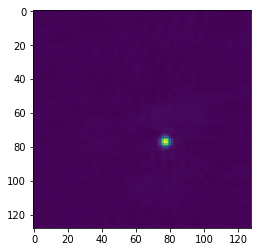

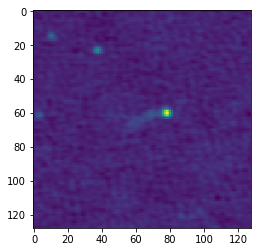

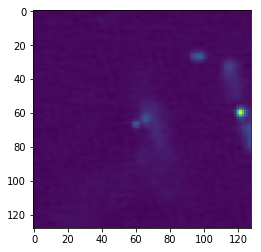

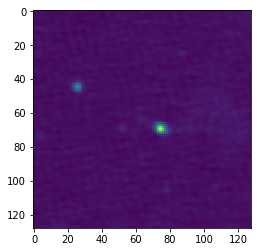

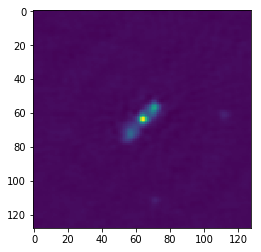

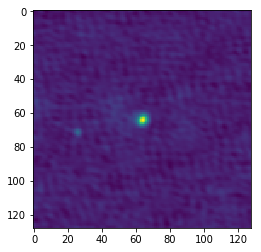

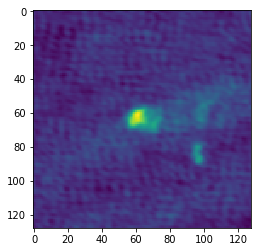

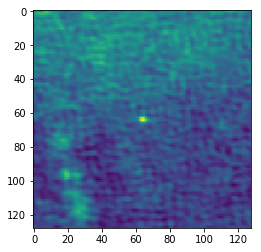

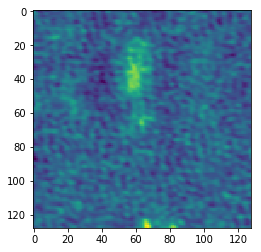

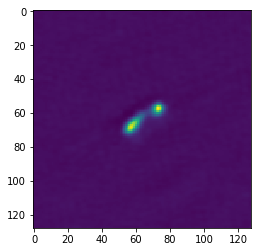

In [23]:
for i in range(0, n_images):
    image_data = fits.getdata('data/dataset'+'/'+image_multi_random[i])
    plt.figure()
    plt.imshow(image_data)

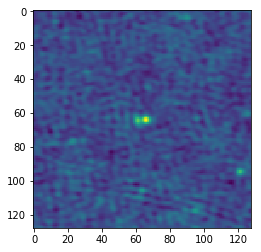

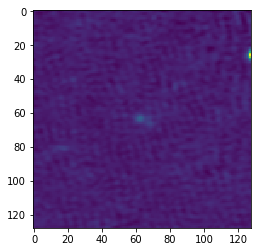

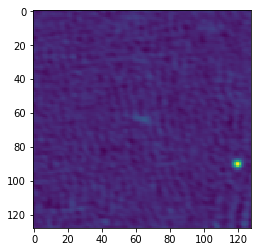

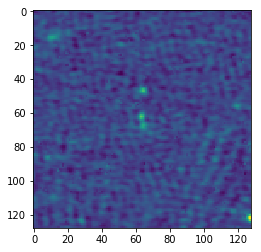

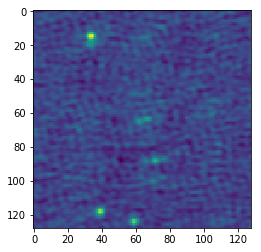

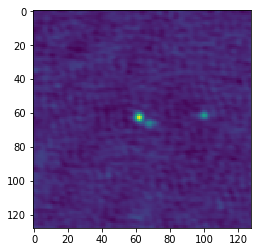

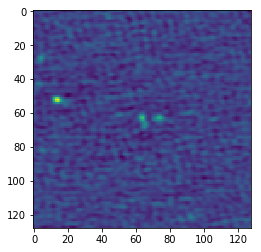

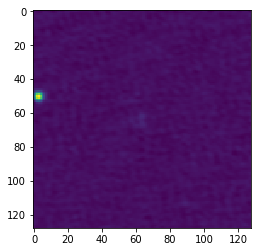

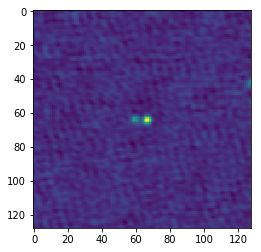

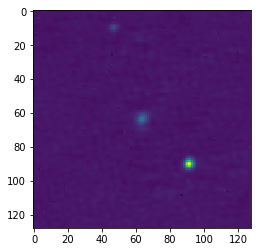

In [20]:
for i in range(0, n_images):
    image_data = fits.getdata('data/dataset'+'/'+image_deblend_random[i])
    plt.figure()
    plt.imshow(image_data)

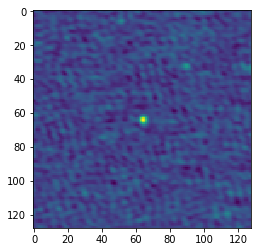

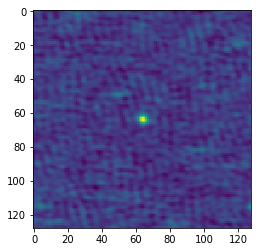

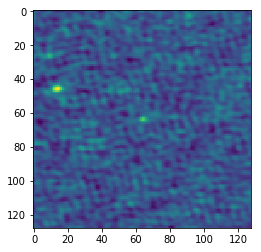

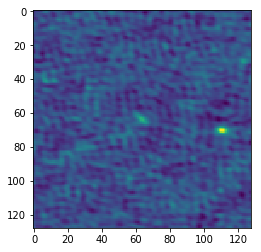

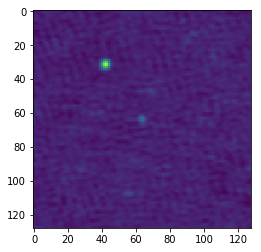

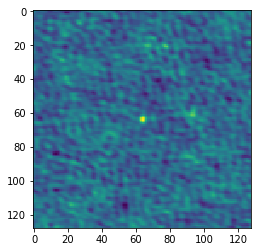

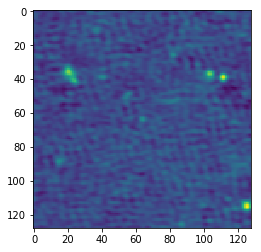

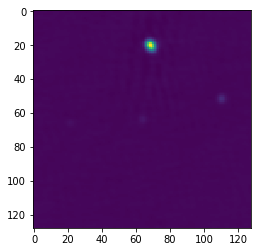

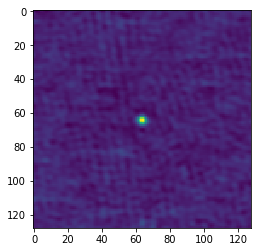

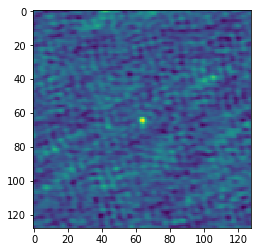

In [21]:
for i in range(0, n_images):
    image_data = fits.getdata('data/dataset'+'/'+image_single_random[i])
    plt.figure()
    plt.imshow(image_data)